In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
sys.path.insert(0, os.path.abspath('../palin/python'))

In [619]:
#from palin.simulation import Experiment
from palin.simulation.experiment import Experiment
from palin.simulation.analyser import Analyser
from palin.simulation.experiments.simple_experiment import SimpleExperiment
from palin.simulation.experiments.double_pass_experiment import DoublePassExperiment
from palin.simulation.trial import Int2Trial, Int1Trial 
from palin.simulation.observers.linear_observer import LinearObserver
from palin.simulation.analysers.kernel_distance import KernelDistance
from palin.simulation.analysers.internal_noise_value import InternalNoiseValue
from palin.kernels.classification_images import ClassificationImage 
from palin.kernels.glm_kernel import GLMKernel
from palin.kernels.glm_hmm_kernel import GLMHMMKernel
from palin.internal_noise.double_pass import DoublePass
from palin.internal_noise.intercept_method import InterceptMethod
from palin.internal_noise.glm_method import GLMMethod
from palin.internal_noise.glm_hmm_method import GLMHMMMethod
from palin.simulation.analysers.agreement_statistics import AgreementStatistics
from palin.internal_noise.agreement_method import AgreementMethod
from palin.simulation.simulation import Simulation as Sim
from palin.simulation.observers.perseverating_observer import PerseveratingObserver

In [ ]:
from skopt import gp_minimize
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from skopt.space import Real, Integer
import pickle

In [6]:
import numpy.random as npr
import ssm
from ssm.util import find_permutation
npr.seed(0)

## Fit GLM-HMM and perform recovery analysis: Maximum Likelihood Estimation

## 2. Input Driven Observations
We create a HMM with input-driven observations and 'standard' (stationary) transitions with the following line:  
```python
        ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", observation_kwargs=dict(C=num_categories), transitions="standard")
```

As in Ashwood et al. (2020), we are going to model an animal's binary choice data during a decision-making task, so we will set `num_categories=2` because the animal only has two options available to it. We will also set `obs_dim = 1` because the dimensionality of the observation data is 1 (if we were also modeling, for example, the binned reaction time of the animal, we could set `obs_dim = 2`).  For the sake of simplicity, we will assume that an animal's choice in a particular state is only affected by the external stimulus associated with that particular trial, and its innate choice bias. Thus, we will set `input_dim = 2` and we will simulate input data that resembles sequences of stimuli in what follows.  In Ashwood et al. (2020), they found that many mice used 3 decision-making states when performing 2AFC tasks. We will, thus, set `num_states = 3`.

### 2a. Initialize GLM-HMM

In [18]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

In [17]:
np.random.normal(3, 2.5, size=7)

array([4.68073689, 4.01865459, 1.07520981, 4.34812298, 1.31416835,
       3.0795764 , 1.4103848 ])

### 2b. Specify parameters of generative GLM-HMM

Let's update the weights and transition matrix for the true GLM-HMM so as to bring the GLM-HMM to the parameter regime that real animals use (according to Ashwood et al. (2020)):

In [19]:
gen_weights = np.array([[[10, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

Text(0.5, 1.0, 'Generative transition matrix')

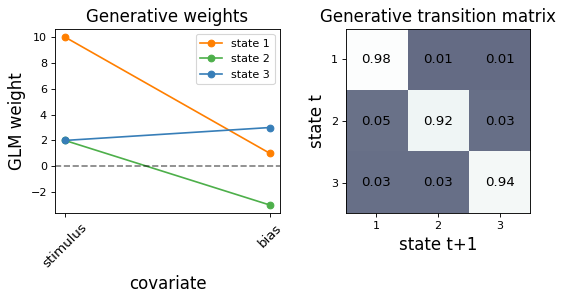

In [20]:
# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

### 2c. Create external input sequences

Simulate an example set of external inputs for each trial in a session. We will create an array of size `(num_sess x num_trials_per_sess x num_covariates)`. As in Ashwood et al. (2020), for each trial in a session we will include the stimulus presented to the animal at that trial, as well as a '1' as the second covariate (so as to capture the animal's innate bias for one of the two options available to it). We will simulate stimuli sequences so as to resemble the sequences of stimuli in the International Brain Laboratory et al. (2020) task.

In [21]:
num_sess = 20 # number of example sessions
num_trials_per_sess = 100 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

### 2d. Simulate states and observations with generative model

In [22]:
# Generate a sequence of latents and choices for each session
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

Text(0, 0.5, 'observation class')

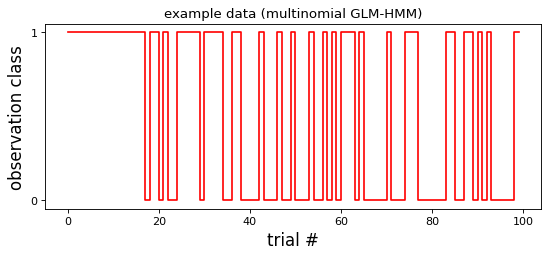

In [24]:
# plot example data:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.step(range(100),true_choices[0][range(100)], color = "red")
plt.yticks([0, 1])
plt.title("example data (multinomial GLM-HMM)")
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("observation class", fontsize = 15)

In [25]:
# Calculate true loglikelihood
true_ll = true_glmhmm.log_probability(true_choices, inputs=inpts) 
print("true ll = " + str(true_ll))

true ll = -785.7998285822409


## 3. Fit GLM-HMM and perform recovery analysis

### 3a. Maximum Likelihood Estimation

Now we instantiate a new GLM-HMM and check that we can recover the generative parameters in simulated data:

In [26]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

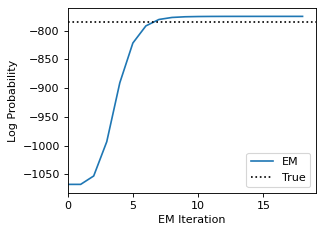

In [27]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### 3b. Retrieved parameters

Compare retrieved weights and transition matrices to generative parameters. To do this, we may first need to permute the states of the fit GLM-HMM relative to the
generative model.  One way to do this uses the `find_permutation` function from `ssm`:

In [28]:
new_glmhmm.permute(find_permutation(true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

Now plot generative and retrieved weights for GLMs (analogous plot to Figure S1c in 
Ashwood et al. (2020)):

Text(0.5, 1.0, 'Weight recovery')

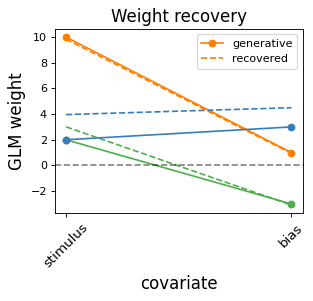

In [29]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

Now plot generative and retrieved transition matrices (analogous plot to Figure S1c in 
Ashwood et al. (2020)):

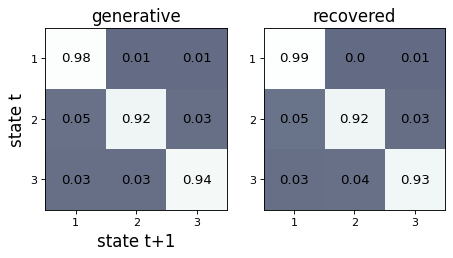

In [30]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


### 3c. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [31]:
# Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices, inpts)]

Text(0, 0.5, 'p(state)')

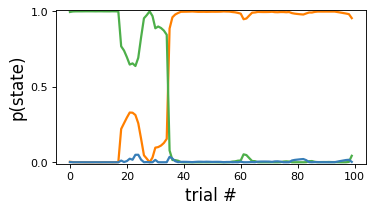

In [32]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [33]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

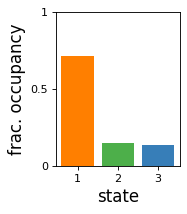

In [34]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

## 4. Fit GLM-HMM and perform recovery analysis: Maximum A Priori Estimation

Above, we performed Maximum Likelihood Estimation to retrieve the generative parameters of the GLM-HMM in simulated data. In the small data regime, where we do not have many trials available to us, we may instead want to perform Maximum A Priori (MAP) Estimation in order to incorporate a prior term and restrict the range for the best fitting parameters. Unfortunately, what is meant by 'small data regime' is problem dependent and will be affected by the number of states in the generative GLM-HMM, and the specific parameters of the generative model, amongst other things. In practice, we may perform both Maximum Likelihood Estimation and MAP estimation and compare the ability of the fit models to make predictions on held-out data (see Section 5 on Cross-Validation below).  

The prior we consider for the GLM-HMM is the product of a Gaussian prior on the GLM weights, $W$, and a Dirichlet prior on the transition matrix, $A$:

$$
\begin{align}
\Pr(W, A) &= \mathcal{N}(W|0, \Sigma) \Pr(A|\alpha) \\&= \mathcal{N}(W|0, diag(\sigma^{2}, \cdots, \sigma^{2})) \prod_{j=1}^{K} \dfrac{1}{B(\alpha)} \prod_{k=1}^{K} A_{jk}^{\alpha -1}
\end{align}
$$

There are two hyperparameters controlling the strength of the prior: $\sigma$ and $\alpha$.  The larger the value of $\sigma$ and if $\alpha = 1$, the more similar MAP estimation will become to Maximum Likelihood Estimation, and the prior term will become an additive offset to the objective function of the GLM-HMM that is independent of the values of $W$ and $A$.  In comparison, setting $\sigma = 2$ and $\alpha = 2$ will result in the prior no longer being independent of $W$ and $\alpha$.  

In order to perform MAP estimation for the GLM-HMM with `ssm`, the new syntax is:

```python
ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
```

where `prior_sigma` is the $\sigma$ parameter from above, and `prior_alpha` is the $\alpha$ parameter.

In [35]:
# Instantiate GLM-HMM and set prior hyperparameters
prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

In [36]:
# Fit GLM-HMM with MAP estimation:
_ = map_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

Compare final likelihood of data with MAP estimation and MLE to likelihood under generative model (note: we cannot use log_probability that is output of `fit` function as this incorporates prior term, which is not comparable between generative and MAP models). We want to check that MAP and MLE likelihood values are higher than true likelihood; if they are not, this may indicate a poor initialization and that we should refit these models.

In [37]:
true_likelihood = true_glmhmm.log_likelihood(true_choices, inputs=inpts)
mle_final_ll = new_glmhmm.log_likelihood(true_choices, inputs=inpts) 
map_final_ll = map_glmhmm.log_likelihood(true_choices, inputs=inpts) 

Text(0, 0.5, 'loglikelihood')

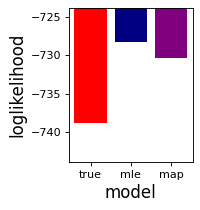

In [38]:
# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [true_likelihood, mle_final_ll, map_final_ll]
colors = ['Red', 'Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((true_likelihood-5, true_likelihood+15))
plt.xticks([0, 1, 2], ['true', 'mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

## 5. Cross Validation

To assess which model is better - the model fit via Maximum Likelihood Estimation, or the model fit via MAP estimation - we can investigate the predictive power of these fit models on held-out test data sets.

In [39]:
# Create additional input sequences to be used as held-out test data
num_test_sess = 10
test_inpts = np.ones((num_test_sess, num_trials_per_sess, input_dim)) 
test_inpts[:,:,0] = np.random.choice(stim_vals, (num_test_sess, num_trials_per_sess)) 
test_inpts = list(test_inpts)

In [40]:
# Create set of test latents and choices to accompany input sequences:
test_latents, test_choices = [], []
for sess in range(num_test_sess):
    test_z, test_y = true_glmhmm.sample(num_trials_per_sess, input=test_inpts[sess])
    test_latents.append(test_z)
    test_choices.append(test_y)

In [41]:
# Compare likelihood of test_choices for model fit with MLE and MAP:
mle_test_ll = new_glmhmm.log_likelihood(test_choices, inputs=test_inpts) 
map_test_ll = map_glmhmm.log_likelihood(test_choices, inputs=test_inpts) 

Text(0, 0.5, 'loglikelihood')

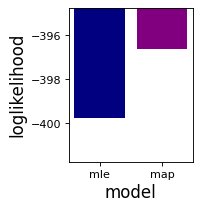

In [42]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_test_ll, map_test_ll]
colors = ['Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((mle_test_ll-2, mle_test_ll+5))
plt.xticks([0, 1], ['mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

Here we see that the model fit with MAP estimation achieves higher likelihood on the held-out dataset than the model fit with MLE, so we would choose this model as the best model of animal decision-making behavior (although we'd probably want to perform multiple fold cross-validation to be sure that this is the case in all instantiations of test data).   

Let's finish by comparing the retrieved weights and transition matrices from MAP estimation to the generative parameters.

In [46]:
from ssm.util import find_permutation

map_glmhmm.permute(find_permutation(true_latents[0], map_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

AssertionError: 

Text(0.5, 1.0, 'MAP')

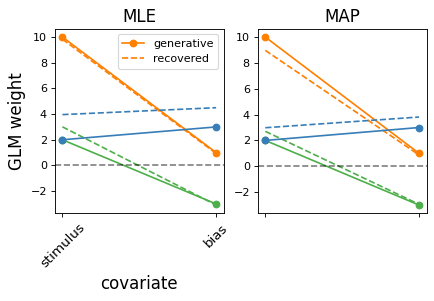

In [47]:
fig = plt.figure(figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
plt.subplot(1,2,1)
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0: # show labels only for first state
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k],
                 lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = 'recovered', linestyle='--')   
    else:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], 
                 lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MLE", fontsize = 15)
plt.legend()

plt.subplot(1,2,2)
recovered_weights = map_glmhmm.observations.params
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k],
             lw=1.5, label="", linestyle = '-')
    plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                 lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.xticks([0, 1], ['', ''], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MAP", fontsize = 15)

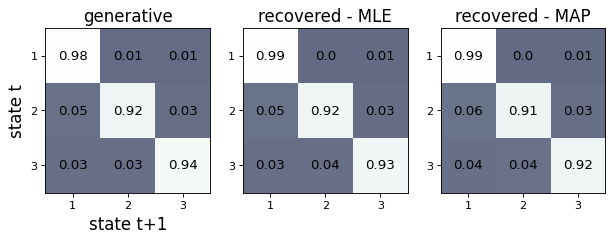

In [48]:
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 3, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MLE", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


plt.subplot(1, 3, 3)
recovered_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MAP", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

## Test GLM HMM

In [26]:
# Create a simple experiment
exp = SimpleExperiment(
    n_trials=150,
    trial_type=Int2Trial,  # Replace with your trial type class
    n_features=7,
    external_noise_std=100
)

In [27]:
# Initialize PerseveratingObserver with a random kernel
obs = PerseveratingObserver.with_random_kernel(
    n_features=exp.n_features,
    internal_noise_std=4,
    criteria=0,
    transition_matrix=[[0.9, 0.1], [0.01, 0.99]]
)

# Get responses and state sequence
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)
# states = obs.last_state_sequence
# stimulus_values = [trial.stims for trial in exp.trials]

# Print results
print("Responses:", responses)
#print("States:", states)
# print("Stimulus Values:", stimulus_values)


Responses: [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
responses_df.head(17)

,trial,stim,feature,value,response
0,0,0,0,85.464273,True
1,0,0,1,-106.600218,True
2,0,0,2,75.784919,True
3,0,0,3,3.575972,True
4,0,0,4,192.111598,True
5,0,0,5,-81.603735,True
6,0,0,6,11.800343,True
7,0,1,0,-182.930467,False
8,0,1,1,-21.316204,False
9,0,1,2,-36.369816,False


In [218]:
file_path = 'revcor_data.csv'
results_df = pd.read_csv(file_path)
print(results_df[results_df.type=='patients'].subject.unique())
results_df

[26 22 23 24 25 31 32 33 34 27 28 29 30 42 43 35 36 37 38 39 40 41]


,Unnamed: 0,trial,block,date,stim,stim_order,response,rt,segment,segment_time,pitch,experimentor,type,session,subject
0,0,0,1,2024-03-04T12:39:01.724Z,male_vraiment_flat_197.wav,0,True,1369.0,0,0.000000,7.012988,aynaz,controls,1,2
1,1,0,1,2024-03-04T12:39:01.724Z,male_vraiment_flat_197.wav,0,True,1369.0,1,0.071043,64.551185,aynaz,controls,1,2
2,2,0,1,2024-03-04T12:39:01.724Z,male_vraiment_flat_197.wav,0,True,1369.0,2,0.142086,-65.392523,aynaz,controls,1,2
3,3,0,1,2024-03-04T12:39:01.724Z,male_vraiment_flat_197.wav,0,True,1369.0,3,0.213129,18.180118,aynaz,controls,1,2
4,4,0,1,2024-03-04T12:39:01.724Z,male_vraiment_flat_197.wav,0,True,1369.0,4,0.284172,-30.775220,aynaz,controls,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163795,163795,150,3,2018-05-13 00:00:00,Sub35_Trial150_1.wav,1,False,565.0,2,2.000000,-66.318857,jeulin,controls,2,21
163796,163796,150,3,2018-05-13 00:00:00,Sub35_Trial150_1.wav,1,False,565.0,3,3.000000,92.591386,jeulin,controls,2,21
163797,163797,150,3,2018-05-13 00:00:00,Sub35_Trial150_1.wav,1,False,565.0,4,4.000000,111.074064,jeulin,controls,2,21
163798,163798,150,3,2018-05-13 00:00:00,Sub35_Trial150_1.wav,1,False,565.0,5,5.000000,7.538058,jeulin,controls,2,21


In [342]:
print(results_df[results_df.type=='patients'].subject.unique())

[26 22 23 24 25 31 32 33 34 27 28 29 30 42 43 35 36 37 38 39 40 41]


In [873]:
responses_df=results_df[(results_df.session==1)&(results_df.subject==40)][['trial','response','segment','stim_order','pitch']].reset_index(drop=True)
responses_df.rename(columns={'response':'response','segment':'feature','stim_order':'stim','pitch':'value'},inplace=True)
responses_df

,trial,response,feature,stim,value
0,1,True,0,0,53.757388
1,1,True,1,0,92.309894
2,1,True,2,0,39.819662
3,1,True,3,0,-19.391832
4,1,True,4,0,-39.273182
...,...,...,...,...,...
2095,150,False,2,1,0.292685
2096,150,False,3,1,99.188948
2097,150,False,4,1,-24.475905
2098,150,False,5,1,5.194246


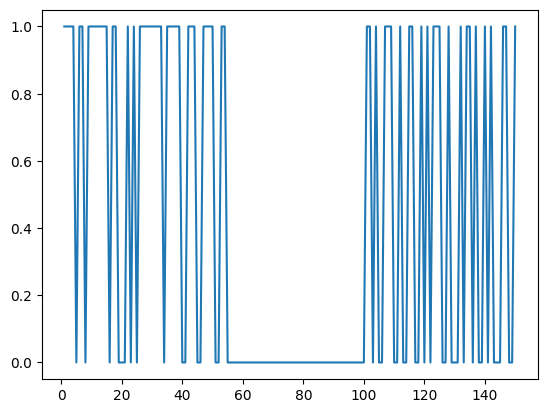

In [874]:
patient_responses = responses_df[(responses_df.stim==0)].groupby('trial')['response'].first()
plt.plot(patient_responses)

In [875]:
best_priors = {
    'mean_value_1': 0.91,
    'mean_value_2': 2.43,
    'sigma_value_1': 3.79,
    'sigma_value_2': 2.43,
    'alpha_value': 1.82
}
kernel, posterior_probs, predicted_states,recovered_trans_mat= GLMHMMKernel.extract_single_kernel(responses_df, best_priors=best_priors)
print("Extracted Kernel:", kernel)
print("posterior_probs:", posterior_probs)
print("predicted_states:", predicted_states)
print("recovered_trans_mat:", recovered_trans_mat)

  0%|          | 0/200 [00:00<?, ?it/s]

Extracted Kernel: [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.44834665e+00]]

 [[ 3.22648397e-03 -1.54203137e-04  9.29751521e-04  3.18514208e-03
   -2.15612923e-03 -3.08840860e-03  1.98378182e-03  0.00000000e+00]]]
posterior_probs: [[1.03167655e-03 9.98968323e-01]
 [4.53191321e-03 9.95468087e-01]
 [5.07399645e-03 9.94926004e-01]
 [4.88080477e-03 9.95119195e-01]
 [3.43717196e-03 9.96562828e-01]
 [1.68132237e-04 9.99831868e-01]
 [1.20611642e-03 9.98793884e-01]
 [1.26662668e-03 9.98733373e-01]
 [3.04006488e-04 9.99695994e-01]
 [4.36249154e-03 9.95637508e-01]
 [9.19957920e-03 9.90800421e-01]
 [1.26774437e-02 9.87322556e-01]
 [1.18647415e-02 9.88135259e-01]
 [1.15917384e-02 9.88408262e-01]
 [9.80169770e-03 9.90198302e-01]
 [6.02620316e-03 9.93973797e-01]
 [6.63807778e-04 9.99336192e-01]
 [5.98109290e-03 9.94018907e-01]
 [1.03421258e-02 9.89657874e-01]
 [1.46575725e-02 9.85342427e-01]
 [1.29451971e-02 9.87054803e-01

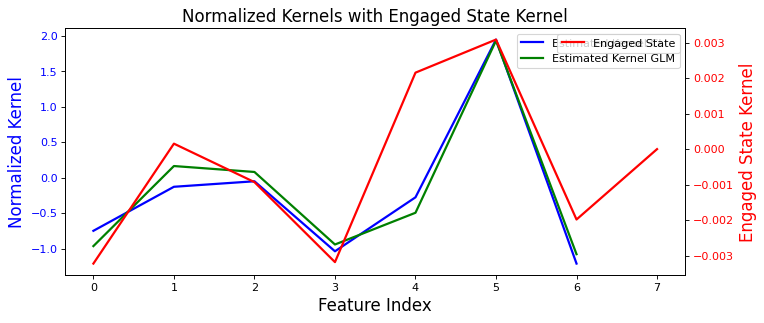

In [876]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')

# Primary Y-Axis: Normalized Kernels
ax1.plot(ClassificationImage.normalize_kernel(ClassificationImage.extract_single_kernel(responses_df)),
         label='Estimated Kernel CI', linestyle='-', linewidth=2, color='blue')
ax1.plot(GLMKernel.normalize_kernel(GLMKernel.extract_single_kernel(responses_df)),
         label='Estimated Kernel GLM', linestyle='-', linewidth=2, color='green')

# Configure primary Y-axis
ax1.set_xlabel('Feature Index', fontsize=15)
ax1.set_ylabel('Normalized Kernel', fontsize=15, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper right')

# Secondary Y-Axis: Engaged State Kernel
ax2 = ax1.twinx()
ax2.plot(kernel[1][0] * -1, label="Engaged State", color='red', linestyle='-', linewidth=2)
# Configure secondary Y-axis
ax2.set_ylabel('Engaged State Kernel', fontsize=15, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='best')

# Title
ax1.set_title('Normalized Kernels with Engaged State Kernel', fontsize=15)

# Show the plot
plt.show()

In [877]:
state_1_trials = np.where(np.argmax(posterior_probs, axis=1) == 1)[0]
state_1_responses_df = responses_df[responses_df['trial'].isin(state_1_trials)].reset_index(drop=True)
print(len(state_1_trials))


105


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


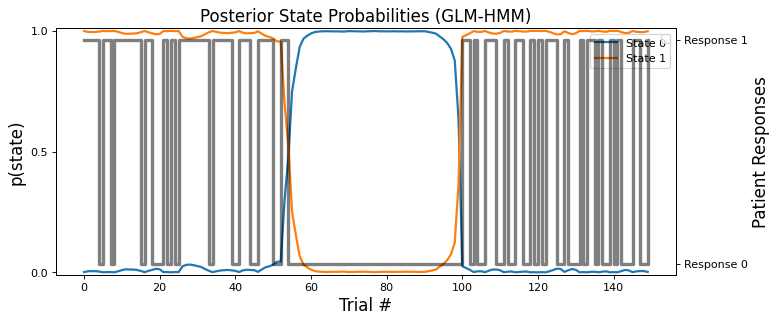

In [878]:
# Visualization
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')

# Number of states in the model
num_states = posterior_probs.shape[1]

# Plot posterior probabilities for each state
for k in range(num_states):
    ax1.plot(posterior_probs[:, k], label=f"State {k}", lw=2)

# Configure primary axis
ax1.set_ylim((-0.01, 1.01))
ax1.set_yticks([0, 0.5, 1])
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("p(state)", fontsize=15)
ax1.set_title("Posterior State Probabilities (GLM-HMM)", fontsize=15)
ax1.legend()

# ax2 = ax1.twinx()
# ax2.step(range(len(responses)), responses, where='post', linewidth=3, color='black', alpha=0.5)
# ax2.set_yticks([0, 1])
# ax2.set_yticklabels(['Response 0', 'Response 1'])
# ax2.set_ylabel('Responses', fontsize=15)
patient_responses = responses_df[responses_df['stim'] == 0].groupby('trial')['response'].first()
ax2 = ax1.twinx()
ax2.step(range(len(patient_responses)), patient_responses, where='post', linewidth=3, color='black', alpha=0.5)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Response 0', 'Response 1'])
ax2.set_ylabel('Patient Responses', fontsize=15)
ax2.legend(loc='best')
# # Show the plot
plt.show()

In [879]:
print(GLMMethod.extract_single_internal_noise(responses_df, glm_model_file='glm_model.pkl'))
print(InterceptMethod.extract_single_internal_noise(responses_df, agreement_model_file='agreement_model_large.csv', kernel_extractor=None))
print(DoublePass.extract_single_internal_noise(responses_df, agreement_model_file='agreement_model_large.csv'))

5.2738126252123205
4.3
4.2


In [880]:
print(GLMMethod.extract_single_internal_noise(state_1_responses_df, glm_model_file='glm_model.pkl'))
print(InterceptMethod.extract_single_internal_noise(state_1_responses_df, agreement_model_file='agreement_model_large.csv', kernel_extractor=None))
print(DoublePass.extract_single_internal_noise(state_1_responses_df, agreement_model_file='agreement_model_large.csv'))
# print(GLMHMMMethod.extract_single_internal_noise(responses_df,internal_noise_extractor=DoublePass, agreement_model_file='agreement_model_large.csv'))
# print(GLMHMMMethod.extract_single_internal_noise(responses_df, internal_noise_extractor=InterceptMethod,agreement_model_file='agreement_model_large.csv', kernel_extractor=None))

7.554580891506893
4.1000000000000005
4.6000000000000005


In [882]:
print(GLMHMMMethod.extract_single_internal_noise(responses_df,internal_noise_extractor=GLMMethod,  best_priors=best_priors,glm_model_file='glm_model.pkl',state_to_filter=1))
print(GLMHMMMethod.extract_single_internal_noise(responses_df,internal_noise_extractor=InterceptMethod,  best_priors=best_priors,agreement_model_file='agreement_model_large.csv',state_to_filter=1, kernel_extractor=None))
print(GLMHMMMethod.extract_single_internal_noise(responses_df,internal_noise_extractor=DoublePass,  best_priors=best_priors,agreement_model_file='agreement_model_large.csv',state_to_filter=1))

  0%|          | 0/200 [00:00<?, ?it/s]

7.554580891506893


  0%|          | 0/200 [00:00<?, ?it/s]

4.1000000000000005


  0%|          | 0/200 [00:00<?, ?it/s]

4.6000000000000005


In [767]:
# fig, ax1 = plt.subplots(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

# # Plot the 'true kernel' on the first y-axis
# ax1.plot(obs.kernel, label='True Kernel', color='blue', linestyle='-', linewidth=2)
# ax1.set_xlabel("Feature Index", fontsize=15)
# ax1.set_ylabel("True Kernel", fontsize=15, color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.set_title("Kernel Weights: True vs Engaged State", fontsize=15)

# # Create a twin y-axis for the 'Engaged State' kernel
# ax2 = ax1.twinx()
# ax2.plot(kernel[1][0]*-1, label="Engaged State", color='red', linestyle='-', linewidth=2)
# ax2.set_ylabel("Engaged State Kernel", fontsize=15, color='red')
# ax2.tick_params(axis='y', labelcolor='red')

# # Add legends
# fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))

# # Show the plot
# plt.show()

In [758]:
# GLMMethod.build_model(glm_model_file='glm_model.pkl')
# model_df = AgreementMethod.build_model(agreement_model_file = 'agreement_model_large.csv', 
#                                        internal_noise_range=np.arange(0,5,.1),
#                                         criteria_range=np.arange(-5,5,1), 
#                             # n_repeated_trials=10000, n_runs=5)
#                             n_repeated_trials=100, n_runs=1)

In [644]:
# internal_noise = GLMHMMMethod.extract_single_internal_noise(
#     data_df=responses_df,
#     glm_model_file='glm_model.pkl'
# )

# print("Extracted Internal Noise:", internal_noise)

In [645]:
unique_responses = (
    responses_df[responses_df['stim'] == 0]  
    .groupby('trial')['response']
    .first()  
    .replace({True: 0, False: 1})  
    .tolist()
)
stimulus_values = (
    responses_df.groupby(['trial', 'stim'])['value']
    .apply(list)
    .unstack()
    .apply(lambda x: [x[0], x[1]], axis=1)  
    .tolist()
)
print(unique_responses)
print(stimulus_values)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
[[[-33.116176, -79.722902, -0.174059, 82.274364, -109.731995, -72.48927, 11.511705], [-83.957947, 68.475222, -59.489465, 64.566697, -27.267557, 94.356275, 27.666308]], [[-11.936919, -51.249998, 42.322915, -19.83941, 46.127041, 34.596861, 143.594573], [-84.088119, 11.67797, 70.948823, 101.030552, 35.233409, 70.014692, -21.284009]], [[40.484109, -10.250913, -109.726305, -32.205058, 141.461363, 65.199031, -54.014549], [-54.423844, 81.067183, -60.396049, -65.685418, 141.607211, 37.879388, -52.972183]], [[62.995907, -119.801161, -125.261471, 110.91

In [355]:
print(len(unique_responses))
print(len(stimulus_values))

1000
1000


In [356]:
responses = (
    responses_df[responses_df['stim'] == 0]  
    .groupby('trial')['response']
    .first()  
    .replace({True: 0, False: 1})  
    .tolist()
)
stimulus_values = (
    responses_df.groupby(['trial', 'stim'])['value']
    .apply(list)
    .unstack()
    .apply(lambda x: [x[0], x[1]], axis=1)  
    .tolist()
)
inputs = []
for trial in stimulus_values:
    stim_1 = np.array(trial[0])  # First stimulus
    stim_2 = np.array(trial[1])  # Second stimulus
    trial_diffs = stim_2 - stim_1  # Calculate differences between the two stimuli
    inputs.append(trial_diffs)

# Convert inputs to a numpy array
inputs_array = np.array(inputs)

# Shift responses to create choice history
choice_history_array = pd.Series(responses).shift(1).fillna(0).values.reshape(-1, 1)

# Combine stimulus differences and choice history into a single input array
inputs_array_no_noise = np.hstack((inputs_array, choice_history_array))

# Convert responses to a numpy array
responses_no_noise_array = np.array(responses).reshape(-1, 1)

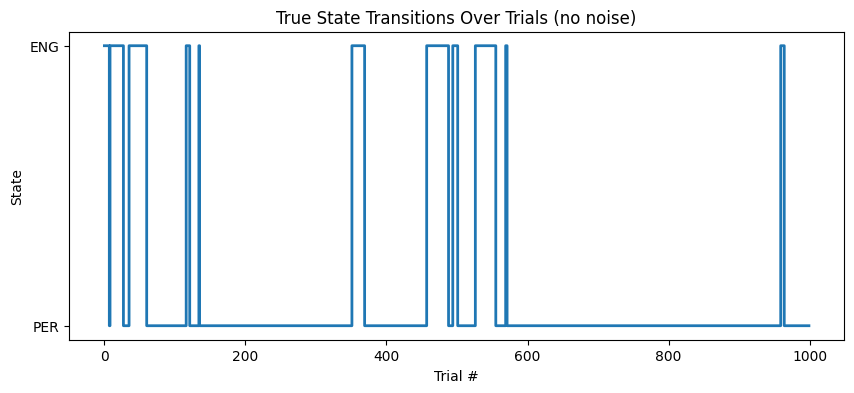

In [357]:
state_numeric_no_noise = [1 if state == "ENG" else 0 for state in states]

plt.figure(figsize=(10, 4))
plt.step(range(len(state_numeric_no_noise)), state_numeric_no_noise, where='post', linewidth=2)
plt.yticks([0, 1], ['PER', 'ENG'])
plt.xlabel('Trial #')
plt.ylabel('State')
plt.title('True State Transitions Over Trials (no noise)')
plt.show()

In [358]:
# Calculate inputs (stimulus differences) and choice history
inputs = []
for trial in stimulus_values:
    stim_1 = np.array(trial[0])  # First stimulus
    stim_2 = np.array(trial[1])  # Second stimulus
    trial_diffs = stim_2 - stim_1  # Calculate differences between the two stimuli
    inputs.append(trial_diffs)

# Convert inputs to a numpy array
inputs_array = np.array(inputs)

# Shift responses to create choice history
choice_history_array = pd.Series(responses).shift(1).fillna(0).values.reshape(-1, 1)

# Combine stimulus differences and choice history into a single input array
inputs_array_no_noise = np.hstack((inputs_array, choice_history_array))

# Convert responses to a numpy array
responses_no_noise_array = np.array(responses).reshape(-1, 1)

# Display the results
print("Inputs (stimulus differences + choice history):")
print(inputs_array_no_noise)
print("\nResponses:")
print(responses_no_noise_array)

Inputs (stimulus differences + choice history):
[[ 148.19941546   56.43540786    6.31079164 ...  107.25077153
   -91.10937064    0.        ]
 [ -90.7744398   -61.41925743  -80.46288519 ...    6.35743851
   173.70470618    0.        ]
 [  63.88701666  124.88357099    7.01907561 ...  153.49309567
  -262.56853729    0.        ]
 ...
 [-173.90161545  194.94648052   47.77121544 ...   27.18069091
    12.078905      0.        ]
 [  60.05911986  145.50308773  -90.69441447 ...   33.53825081
   148.97890579    0.        ]
 [ 149.89084787  -49.90866976  107.86614249 ...  -19.70168353
   120.92097807    0.        ]]

Responses:
[[0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 

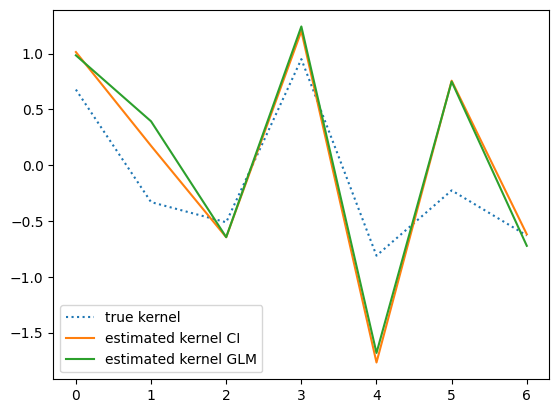

In [359]:
plt.plot(obs.kernel,':',label='true kernel')
plt.plot(ClassificationImage.normalize_kernel(ClassificationImage.extract_single_kernel(responses_df)),
         label='estimated kernel CI')
plt.plot(GLMKernel.normalize_kernel(GLMKernel.extract_single_kernel(responses_df)),
         label='estimated kernel GLM')
plt.legend()


In [360]:
data_best_priors = {
    "best_priors": [
        "best_prior_alpha", 
        "best_mean_value_1", 
        "best_mean_value_2", 
        "best_prior_sigma_1", 
        "best_prior_sigma_2"
    ],
    "mean": [
        1.826908, 
        0.915005, 
        2.435685, 
        3.791094, 
        2.435685
    ]
}
# Create a DataFrame
data_best_priors = pd.DataFrame(data_best_priors)
data_best_priors.set_index('best_priors', inplace=True)

# Save the DataFrame to a CSV file
data_best_priors.to_csv("data_best_priors.csv", index=False)

In [361]:
import numpy as np
import pandas as pd
import pickle
import ssm  # Ensure the ssm library is installed and properly imported

# Define the mean parameter values
mean_values = {
    'sigma_value_1': data_best_priors.loc['best_prior_sigma_1', 'mean'],  # Replace with actual mean
    'sigma_value_2': data_best_priors.loc['best_prior_sigma_2', 'mean'],  # Replace with actual mean
    'alpha_value': data_best_priors.loc['best_prior_alpha', 'mean'],
    'mean_value_1': data_best_priors.loc['best_mean_value_1', 'mean'],
    'mean_value_2': data_best_priors.loc['best_mean_value_2', 'mean']
}

# Fixed parameters for GLM-HMM
num_states = 2
obs_dim = 1
num_categories = 2
input_dim = 8  # 7 stimulus differences + 1 choice history

def fit_glmhmm(params, responses, inputs, saved_states):
    mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value = params

    # Define priors
    prior_means = [(0, mean_value_1), (mean_value_2, 0)]
    prior_sigmas = [(0.01, sigma_value_1), (sigma_value_2, 0.01)]
    prior_alpha = alpha_value

    # Instantiate the GLM-HMM
    map_glmhmm = ssm.HMM(
        num_states, obs_dim, input_dim,
        observations="ind_input_driven_obs",
        observation_kwargs=dict(C=num_categories, prior_means=prior_means, prior_sigmas=prior_sigmas),
        transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
    )

    # Fit the model using EM with MAP estimation
    map_glmhmm.fit(responses, inputs=inputs, method="em", num_iters=500, tolerance=1e-3)

    # Extract posterior probabilities and predicted states
    posterior_probs = map_glmhmm.expected_states(data=responses, input=inputs)[0]
    predicted_states = np.argmax(posterior_probs, axis=1)
    # Convert saved states to numerical format
    state_numeric = [1 if state == "ENG" else 0 for state in saved_states]
    rmse_total = np.mean(predicted_states != state_numeric)

    # Calculate RMSE separately for PER and ENG states
    per_indices = [i for i, state in enumerate(state_numeric) if state == 0]
    rmse_per = np.mean(predicted_states[per_indices] != np.array(state_numeric)[per_indices]) if per_indices else np.nan

    eng_indices = [i for i, state in enumerate(state_numeric) if state == 1]
    rmse_eng = np.mean(predicted_states[eng_indices] != np.array(state_numeric)[eng_indices]) if eng_indices else np.nan

    # Calculate the log likelihood
    log_likelihood = map_glmhmm.log_likelihood(responses, inputs=inputs)

    return (
        rmse_total, rmse_per, rmse_eng, log_likelihood, 
        (prior_means, prior_sigmas, prior_alpha), 
        predicted_states, posterior_probs, 
        map_glmhmm.observations.params[0], map_glmhmm.observations.params[1], 
        np.exp(map_glmhmm.transitions.log_Ps)
    )

# Inputs for one result
responses_array = responses_no_noise_array  # Response array
inputs_with_history = inputs_array_no_noise  # Inputs array
saved_states = states  # True states

# Set fixed parameters as a tuple
fixed_params = (
    mean_values['mean_value_1'],
    mean_values['mean_value_2'],
    mean_values['sigma_value_1'],
    mean_values['sigma_value_2'],
    mean_values['alpha_value']
)

# Fit the model and extract details
best_rmse_total, best_rmse_per, best_rmse_eng, log_likelihood, best_params_full, \
best_states, best_posterior_probs, best_glm_weights_state_1, \
best_glm_weights_state_2, transitions_log_ps = fit_glmhmm(
    fixed_params, responses_array, inputs_with_history, saved_states
)

# Save results
glm_hmm_results_one = {
    'best_rmse_total': best_rmse_total,
    'best_rmse_per': best_rmse_per,
    'best_rmse_eng': best_rmse_eng,
    'log_likelihood': log_likelihood,
    'best_prior_alpha': best_params_full[2],
    'best_mean_value_1': fixed_params[0],
    'best_mean_value_2': fixed_params[1],
    'best_prior_sigma_1': best_params_full[1][0][1],
    'best_prior_sigma_2': best_params_full[1][1][0],
    'best_posterior_probs': best_posterior_probs,
    'glm_weights_state_1': best_glm_weights_state_1,
    'glm_weights_state_2': best_glm_weights_state_2,
    'transitions_log_ps': transitions_log_ps,
}

# Convert to DataFrame
results_df_one = pd.DataFrame([glm_hmm_results_one])
print(results_df_one)

# Save to CSV or pickle
results_df_one.to_csv("glm_hmm_results_one.csv", index=False)
with open("glm_hmm_results_one.pkl", "wb") as f:
    pickle.dump(glm_hmm_results_one, f)


  0%|          | 0/500 [00:00<?, ?it/s]

   best_rmse_total  best_rmse_per  best_rmse_eng  log_likelihood  \
0            0.176       0.199765       0.040268     -455.614746   

   best_prior_alpha  best_mean_value_1  best_mean_value_2  best_prior_sigma_1  \
0          1.826908           0.915005           2.435685            3.791094   

   best_prior_sigma_2                               best_posterior_probs  \
0            2.435685  [[5.511323756750359e-10, 0.9999999994488462], ...   

                                 glm_weights_state_1  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -6.534054...   

                                 glm_weights_state_2  \
0  [[-0.0016242998967896367, -0.00040392164131928...   

                                  transitions_log_ps  
0  [[0.9876083351794612, 0.012391664820539008], [...  


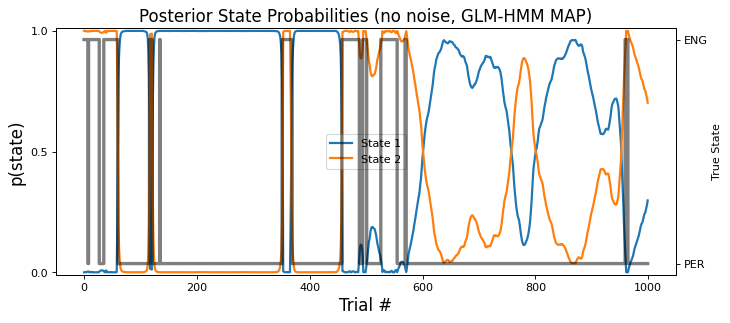

In [362]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
posterior_probs_no_noise =results_df_one.best_posterior_probs.values[0]
num_states = posterior_probs_no_noise.shape[1]
for k in range(num_states):
    ax1.plot(posterior_probs_no_noise[:, k], label="State " + str(k + 1) , lw=2)

ax1.set_ylim((-0.01, 1.01))
ax1.set_yticks([0, 0.5, 1])
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("p(state)", fontsize=15)
ax1.set_title("Posterior State Probabilities (no noise, GLM-HMM MAP)", fontsize=15)
ax1.legend()

ax2 = ax1.twinx()
ax2.step(range(len(state_numeric_no_noise)), state_numeric_no_noise, where='post', linewidth=3, color='black', alpha=0.5)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['PER', 'ENG'])
ax2.set_ylabel('True State')

plt.show()

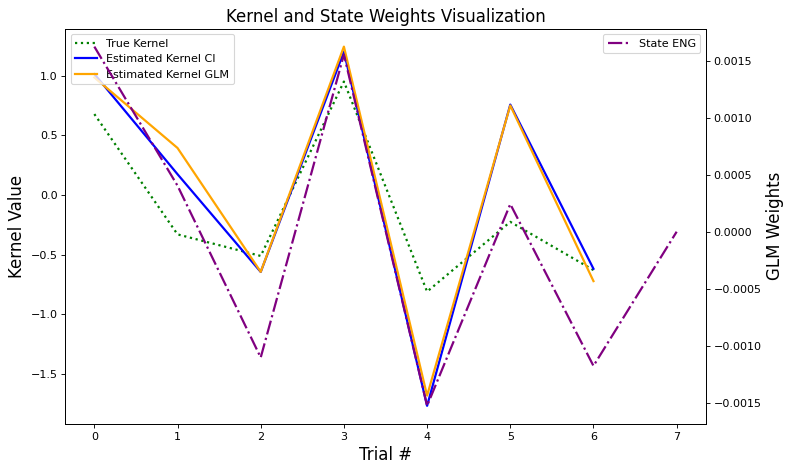

In [363]:

# Define data (replace with actual values)
true_kernel = obs.kernel  # True kernel
ci_kernel = ClassificationImage.normalize_kernel(
    ClassificationImage.extract_single_kernel(responses_df)
)
glm_kernel = GLMKernel.normalize_kernel(
    GLMKernel.extract_single_kernel(responses_df)
)
state_eng_weights = results_df_one.glm_weights_state_2.values[0][0] * -1

# Create the figure and first axis
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

# Plot true kernel and estimated kernels
ax1.plot(true_kernel, ':', label='True Kernel', linewidth=2, color='green')
ax1.plot(ci_kernel, label='Estimated Kernel CI', linewidth=2, color='blue')
ax1.plot(glm_kernel, label='Estimated Kernel GLM', linewidth=2, color='orange')

# Customize ax1
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("Kernel Value", fontsize=15)
ax1.set_title("Kernel and State Weights Visualization", fontsize=15)
ax1.legend(loc='upper left')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot GLM weights for State PER and State ENG
#ax2.plot(state_per_weights, label="State PER", linewidth=2, linestyle='--', color='red')
ax2.plot(state_eng_weights, label="State ENG", linewidth=2, linestyle='-.', color='purple')

# Customize ax2
ax2.set_ylabel("GLM Weights", fontsize=15)
ax2.legend(loc='upper right')

# Finalize and display the plot
plt.tight_layout()
plt.show()


In [364]:
print(ClassificationImage.extract_single_kernel(responses_df))
print(GLMKernel.extract_single_kernel(responses_df))
print(results_df_one.glm_weights_state_2.values[0][0] * -1)

         kernel_value
feature              
0            3.997151
1            0.685338
2           -2.542140
3            4.734322
4           -6.964240
5            2.985232
6           -2.438123
         kernel_value
feature              
0            0.000369
1            0.000147
2           -0.000241
3            0.000466
4           -0.000630
5            0.000281
6           -0.000270
[ 0.0016243   0.00040392 -0.0011038   0.00155413 -0.00152783  0.00024247
 -0.00117751 -0.        ]


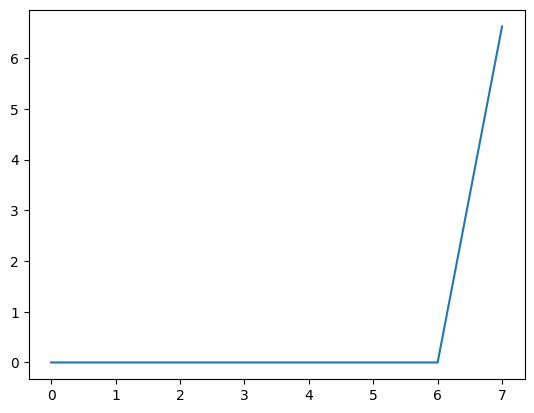

In [331]:
plt.plot(results_df_one.glm_weights_state_1.values[0][0]*-1, label="State PER")

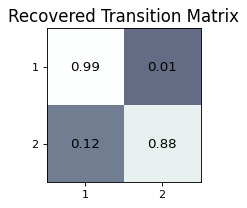

In [332]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
map_recovered_trans_mat = results_df_one.transitions_log_ps.values[0]
plt.imshow(map_recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(map_recovered_trans_mat.shape[0]):
    for j in range(map_recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(map_recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("Recovered Transition Matrix", fontsize=15)
plt.show()

In [333]:
print(np.where(np.argmax(posterior_probs_no_noise, axis=1) == 1)[0])
print(len (np.where(np.argmax(posterior_probs_no_noise, axis=1) == 1)[0]))
state_1_trials = np.where(np.argmax(posterior_probs_no_noise, axis=1) == 1)[0]
state_1_responses_df = responses_df[responses_df['trial'].isin(state_1_trials)].reset_index(drop=True)
state_1_responses_df

[171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 232 233 234
 235 236 237 238 239 259 260 261 262 263 264 511 512 513 514 515 516 738
 739 740 741 742 743 744 745 746 747 762 979 980 981 982 983 984 985 986
 987 988 989 990 991 992 993 994 995 996 997 998 999]
67


,trial,stim,feature,value,response
0,171,0,0,-59.836063,True
1,171,0,1,-29.112801,True
2,171,0,2,-116.386611,True
3,171,0,3,-12.255191,True
4,171,0,4,-112.475227,True
...,...,...,...,...,...
933,999,1,2,-7.103438,True
934,999,1,3,-51.112943,True
935,999,1,4,39.345660,True
936,999,1,5,112.697274,True


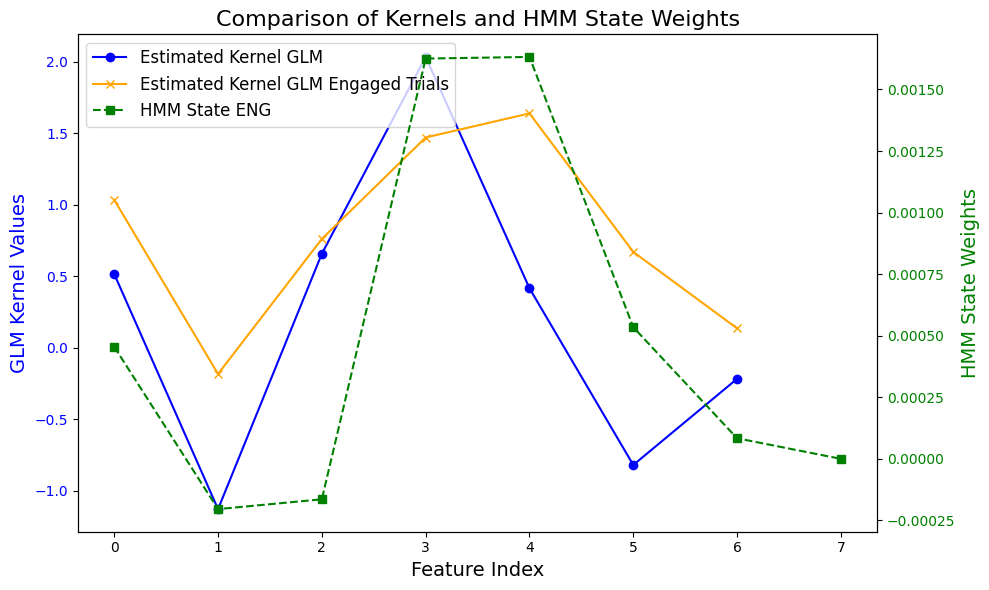

In [319]:
glm_kernel= GLMKernel.normalize_kernel(GLMKernel.extract_single_kernel(responses_df))
glm_kernel_eng = GLMKernel.normalize_kernel(GLMKernel.extract_single_kernel(state_1_responses_df))
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GLM kernel and GLM kernel for engaged trials on the first y-axis
ax1.plot(glm_kernel, label='Estimated Kernel GLM', color='blue', marker='o')
ax1.plot(glm_kernel_eng, label='Estimated Kernel GLM Engaged Trials', color='orange', marker='x')
ax1.set_xlabel("Feature Index", fontsize=14)
ax1.set_ylabel("GLM Kernel Values", fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Comparison of Kernels and HMM State Weights", fontsize=16)

# Create the second y-axis for HMM State ENG weights
ax2 = ax1.twinx()
ax2.plot(state_eng_weights, label="HMM State ENG", color='green', linestyle='--', marker='s')
ax2.set_ylabel("HMM State Weights", fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [878]:
# import numpy as np
# import pandas as pd
# import pickle
# import ssm  # Ensure the ssm library is installed and properly imported

# # Calculate inputs (stimulus differences) and choice history
# inputs = []
# for trial in stimulus_values:
#     stim_1 = np.array(trial[0])  # First stimulus
#     stim_2 = np.array(trial[1])  # Second stimulus
#     trial_diffs = stim_2 - stim_1  # Calculate differences between the two stimuli
#     inputs.append(trial_diffs)

# # Convert inputs to a numpy array
# inputs_array = np.array(inputs)

# # Shift responses to create choice history
# choice_history_array = pd.Series(responses).shift(1).fillna(0).values.reshape(-1, 1)

# # Combine stimulus differences and choice history into a single input array
# inputs_array_no_noise = np.hstack((inputs_array, choice_history_array))

# # Convert responses to a numpy array
# responses_no_noise_array = np.array(responses).reshape(-1, 1)



# data_best_priors = {
#     "best_priors": [
#         "best_prior_alpha", 
#         "best_mean_value_1", 
#         "best_mean_value_2", 
#         "best_prior_sigma_1", 
#         "best_prior_sigma_2"
#     ],
#     "mean": [
#         1.826908, 
#         0.915005, 
#         2.435685, 
#         3.791094, 
#         2.435685
#     ]
# }
# # Create a DataFrame
# data_best_priors = pd.DataFrame(data_best_priors)
# data_best_priors.set_index('best_priors', inplace=True)
# # Define the mean parameter values
# mean_values = {
#     'sigma_value_1': data_best_priors.loc['best_prior_sigma_1', 'mean'],  # Replace with actual mean
#     'sigma_value_2': data_best_priors.loc['best_prior_sigma_2', 'mean'],  # Replace with actual mean
#     'alpha_value': data_best_priors.loc['best_prior_alpha', 'mean'],
#     'mean_value_1': data_best_priors.loc['best_mean_value_1', 'mean'],
#     'mean_value_2': data_best_priors.loc['best_mean_value_2', 'mean']
# }

# # Fixed parameters for GLM-HMM
# num_states = 2
# obs_dim = 1
# num_categories = 2
# input_dim = 8  # 7 stimulus differences + 1 choice history

# def fit_glmhmm(params, responses, inputs, saved_states):
#     mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value = params

#     # Define priors
#     prior_means = [(0, mean_value_1), (mean_value_2, 0)]
#     prior_sigmas = [(0.01, sigma_value_1), (sigma_value_2, 0.01)]
#     prior_alpha = alpha_value

#     # Instantiate the GLM-HMM
#     map_glmhmm = ssm.HMM(
#         num_states, obs_dim, input_dim,
#         observations="ind_input_driven_obs",
#         observation_kwargs=dict(C=num_categories, prior_means=prior_means, prior_sigmas=prior_sigmas),
#         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
#     )

#     # Fit the model using EM with MAP estimation
#     map_glmhmm.fit(responses, inputs=inputs, method="em", num_iters=200, tolerance=1e-3)

#     # Extract posterior probabilities and predicted states
#     posterior_probs = map_glmhmm.expected_states(data=responses, input=inputs)[0]
#     predicted_states = np.argmax(posterior_probs, axis=1)
#     # Convert saved states to numerical format

#     # Calculate the log likelihood
#     log_likelihood = map_glmhmm.log_likelihood(responses, inputs=inputs)

#     return (
#         log_likelihood, 
#         (prior_means, prior_sigmas, prior_alpha), 
#         predicted_states, posterior_probs, 
#         map_glmhmm.observations.params[0], map_glmhmm.observations.params[1], 
#         np.exp(map_glmhmm.transitions.log_Ps)
#     )

# # Inputs for one result
# responses_array = responses_no_noise_array  # Response array
# inputs_with_history = inputs_array_no_noise  # Inputs array
# saved_states = states  # True states

# # Set fixed parameters as a tuple
# fixed_params = (
#     mean_values['mean_value_1'],
#     mean_values['mean_value_2'],
#     mean_values['sigma_value_1'],
#     mean_values['sigma_value_2'],
#     mean_values['alpha_value']
# )

# # Fit the model and extract details
# log_likelihood, best_params_full, \
# best_states, best_posterior_probs, best_glm_weights_state_1, \
# best_glm_weights_state_2, transitions_log_ps = fit_glmhmm(
#     fixed_params, responses_array, inputs_with_history
# )

# # Save results
# glm_hmm_results_one = {
#     'log_likelihood': log_likelihood,
#     'best_prior_alpha': best_params_full[2],
#     'best_mean_value_1': fixed_params[0],
#     'best_mean_value_2': fixed_params[1],
#     'best_prior_sigma_1': best_params_full[1][0][1],
#     'best_prior_sigma_2': best_params_full[1][1][0],
#     'best_posterior_probs': best_posterior_probs,
#     'glm_weights_state_1': best_glm_weights_state_1,
#     'glm_weights_state_2': best_glm_weights_state_2,
#     'transitions_log_ps': transitions_log_ps,
# }

# # Convert to DataFrame
# results_df_one = pd.DataFrame([glm_hmm_results_one])
# print(results_df_one)

# # Save to CSV or pickle
# results_df_one.to_csv("glm_hmm_results_one.csv", index=False)
# with open("glm_hmm_results_one.pkl", "wb") as f:
#     pickle.dump(glm_hmm_results_one, f)


In [879]:
# observer_params = {
#     'kernel': ['random'],  # Random kernel
#     'internal_noise_std': [1],  # Noise level
#     'criteria': [0],  # Decision threshold
#     'transition_matrix': [[[0.9, 0.1], [0.2, 0.8]]]  # Transition probabilities
# }

# experiment_params = {
#     'n_trials': [100],
#     'external_noise_std': [100],
#     'trial_type': [Int2Trial],  # Replace with your trial type
#     'n_features': [6]
# }

# analyser_params = {
#     'internal_noise_extractor': [DoublePass],
#     'model_file': ['agreement_model_large.csv']
# }

# sim = Sim(SimpleExperiment,experiment_params,
#           PerseveratingObserver,observer_params,
#             InternalNoiseValue,analyser_params)

# results = sim.run_all(n_runs=10, multiprocess=False)
# print(results)


In [ ]:
# Define the observer parameters, experiment parameters, and analyser parameters
observer_params = {
    'kernel': ['random'],  # Use a random kernel for simplicity
    'internal_noise_std': np.arange(1,5,0.5),  # Test different levels of internal noise
    'criteria': [0],  # Threshold criteria for decision-making
    'transition_matrix': [[[0.99, 0.01], [0.02, 0.98]]]
}

experiment_params = {
    'n_trials': [150],  # Number of trials per experiment
    'trial_type': [Int2Trial],  # The type of trial (assuming 'Int2Trial' is defined elsewhere)
    'n_features': [7],  # Number of features used in the experiment
    'external_noise_std': [100]  # Standard deviation of external noise
}

analyser_params = {
    'kernel_extractor': [GLMKernel],  # Use GLMModel to extract kernel
    'distance': ['CORR']  # Type of distance metric to use for analysis
}

# Initialize the simulation with the PerseveratingObserver
sim = Sim(SimpleExperiment, experiment_params, 
                 PerseveratingObserver, observer_params, 
                 KernelDistance, analyser_params)

# Run the simulation for all parameter configurations with multiple runs
sim_df = sim.run_all(n_runs=10, multiprocess=False)
sim_df

Processing config 7 run 9: 100%|██████████| 80/80 [00:01<00:00, 48.33it/s]


,config,n_trials,trial_type,n_features,external_noise_std,kernel,internal_noise_std,criteria,transition_matrix,kernel_extractor,distance,run,corr
0,0,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,0,0.795071
1,0,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,1,0.939580
2,0,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,2,0.969489
3,0,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,3,0.670549
4,0,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,4,0.851056
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,7,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,4.5,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,5,0.240818
76,7,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,4.5,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,6,0.420368
77,7,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,4.5,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,7,0.443165
78,7,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,4.5,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,8,0.709397


In [ ]:
# results_ci_no_noise = ClassificationImage.extract_single_kernel(final_df_no_noise).reset_index()
# results_glm_no_noise = GLMKernel.extract_single_kernel(final_df_no_noise).reset_index()

In [ ]:
# stim_values_1 = sim_combined_df.iloc[0]['stim_values']  # Shape: (150, 2, 7)
# responses_1 = np.array(sim_combined_df.iloc[0]['responses'])      # Shape: (150,)
# last_state_sequence_1 = sim_combined_df.iloc[0]['last_state_sequence']  # Shape: (150,)


# # Extracting inputs for the first observer
# inputs_1 = []
# for num_trial, trial in enumerate(stim_values_1):
#     stim_1 = np.array(trial[0])  # First stimulus
#     stim_2 = np.array(trial[1])  # Second stimulus
#     trial_diffs = stim_2 - stim_1  # Calculate differences between the two stimuli
#     inputs_1.append(trial_diffs)


# # Convert inputs and choice history to numpy arrays
# inputs_array_1 = np.array(inputs_1)


# # Adjusting choice history arrays using shifted responses
# choice_history_array_no_noise = pd.Series(responses_1).shift(1).fillna(0).values.reshape(-1, 1)

# # Combine inputs and choice history
# inputs_array_no_noise = np.hstack((inputs_array_1, choice_history_array_no_noise))

# # Convert responses to numpy arrays
# responses_no_noise_array = responses_1.reshape(-1, 1)

# # Display the inputs and responses
# print(inputs_array_no_noise)



In [94]:
# n_trials = 150
# n_features = 8  # 7 stimulus differences + 1 for the last response

# # Random values for 7 stimulus differences, last feature is the last response
# stim_differences = np.random.uniform(-300, 300, (n_trials, n_features - 1))
# last_responses = np.random.choice([0, 1], size=(n_trials, 1))
# inputs_array_no_noise = np.hstack([stim_differences, last_responses])

# # Generate responses for 150 trials as a binary array (0 or 1)
# responses_no_noise_array = np.random.choice([0, 1], size=(n_trials, 1))

# inputs_array_no_noise[:, -1] = np.roll(responses_no_noise_array.flatten(), shift=1)
# inputs_array_no_noise[0, -1] = 0  # Ensure the first trial's last response is 0

# inputs_array_no_noise, responses_no_noise_array



In [95]:
print(inputs_array_no_noise.shape)
print(responses_no_noise_array.shape)

(150, 8)
(150, 1)


In [96]:
glm_no_noise = ssm.HMM(1, 1, 8, observations="input_driven_obs", 
                   observation_kwargs=dict(C=2), transitions="standard")
print(glm_no_noise.observations.params)
print(glm_no_noise.transitions.params)
ll_glm_no_noise=glm_no_noise.fit(responses_no_noise_array, inputs=inputs_array_no_noise, method="em", num_iters=100, tolerance=10**-3)

[[[ 2.20980559 -0.07920937  0.0939683   0.39950668  1.54931126
    0.29285692 -0.10671493 -0.49346002]]]
(array([[0.]]),)


  0%|          | 0/100 [00:00<?, ?it/s]

In [97]:
npr.seed(0)
# Set the parameters of the GLM-HMM
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 8         # input dimensions

In [98]:
glmhmm_no_noise = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
N_iters = 1000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll_no_noise = glmhmm_no_noise.fit(responses_no_noise_array, inputs=inputs_array_no_noise, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [99]:
glm_weights_state_no_noise=glmhmm_no_noise.observations.params
glm_weights_state_1_no_noise = glmhmm_no_noise.observations.params[0]  
glm_weights_state_2_no_noise = glmhmm_no_noise.observations.params[1] 
print(glm_weights_state_1_no_noise)
print(glm_weights_state_2_no_noise)

[[ 4.66091909e-03 -2.95037447e-03 -4.85881294e-03 -4.79550276e-03
  -1.13493621e-03  2.60084788e-03 -2.69398523e-03 -4.73854066e+00]]
[[-2.37397372e-01 -1.22909371e-01  5.76070684e-02 -1.74926276e-02
   7.59907813e-02  1.75038291e-01  1.77583099e-01  8.49656322e+01]]


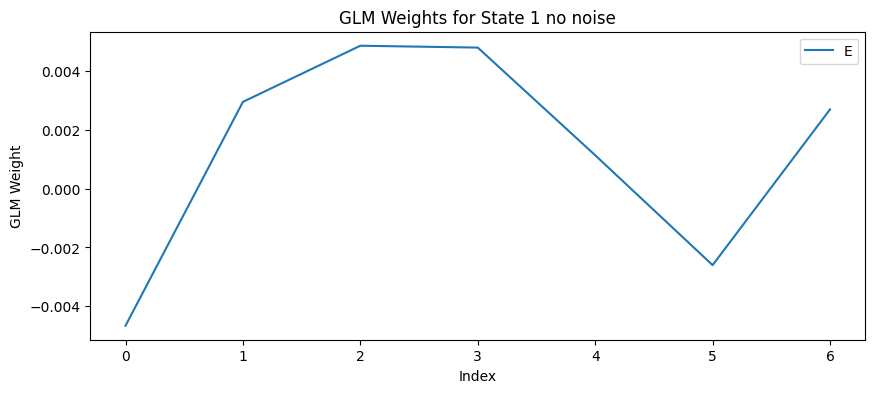

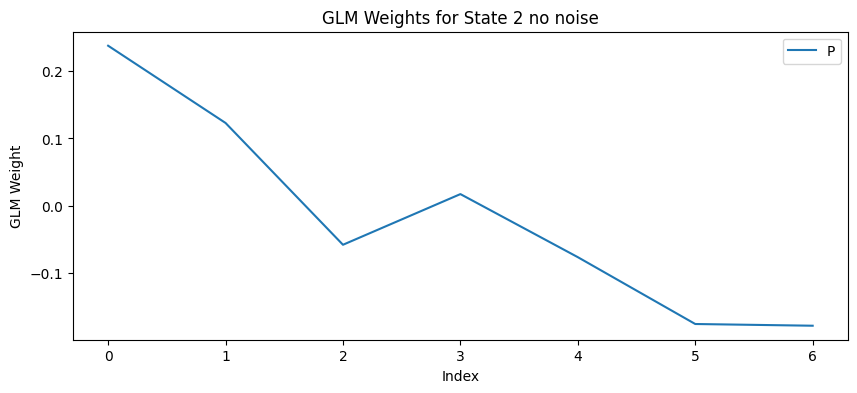

In [102]:
plt.figure(figsize=(10, 4))
for i in range(glm_weights_state_1_no_noise.shape[0]):
    plt.plot(glm_weights_state_1_no_noise[i][:-1], label=f'Row {i}')
plt.xlabel('Index')
plt.ylabel('GLM Weight')
plt.title('GLM Weights for State 1 no noise')
plt.legend('ENG')
plt.show()


plt.figure(figsize=(10, 4))
for i in range(glm_weights_state_2_no_noise.shape[0]):
    plt.plot(glm_weights_state_2_no_noise[i][:-1], label=f'Row {i}')
plt.xlabel('Index')
plt.ylabel('GLM Weight')
plt.title('GLM Weights for State 2 no noise')
plt.legend('PER')
plt.show()


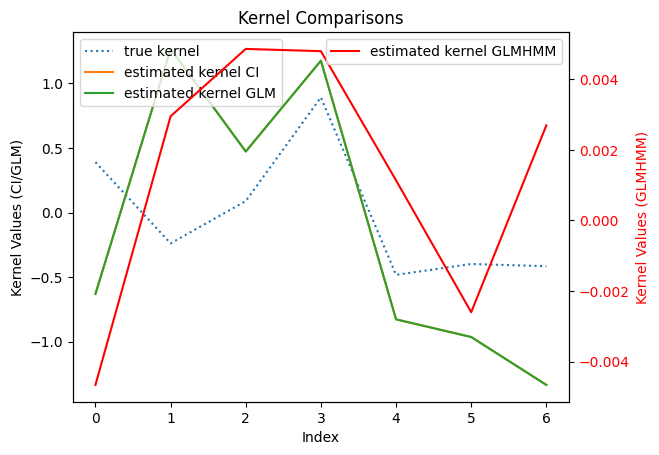

In [104]:
fig, ax1 = plt.subplots()

ax1.plot(obs.kernel, ':', label='true kernel')
ax1.plot(
    ClassificationImage.normalize_kernel(ClassificationImage.extract_single_kernel(responses_df)),
    label='estimated kernel CI'
)
ax1.plot(
    GLMKernel.normalize_kernel(ClassificationImage.extract_single_kernel(responses_df)),
    label='estimated kernel GLM'
)
ax1.set_xlabel("Index")
ax1.set_ylabel("Kernel Values (CI/GLM)")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(glm_weights_state_1_no_noise[i][:-1] * -1, label='estimated kernel GLMHMM', color='red')
ax2.set_ylabel("Kernel Values (GLMHMM)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax2.legend(loc='upper right')

plt.title("Kernel Comparisons")
plt.show()

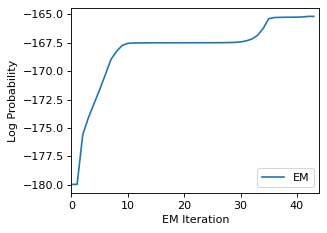

In [105]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll_no_noise, label="EM")
#plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll_no_noise))
plt.ylabel("Log Probability")
plt.show()

In [ ]:
# new_glmhmm.permute(find_permutation(true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

AssertionError: 

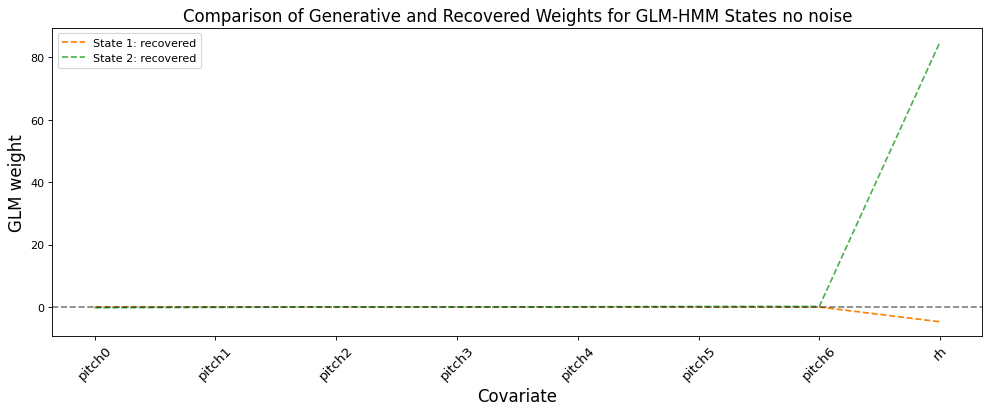

In [107]:
fig = plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8','#984ea3'] 
recovered_weights_no_noise = (glmhmm_no_noise.observations.params)
for k in range(num_states):
    plt.plot(range(input_dim), (recovered_weights_no_noise[k][0])[:], color=cols[k],
             lw=1.5, label=f"State {k+1}: recovered", linestyle='--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariate", fontsize=15)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.xticks(range(input_dim), ['pitch0', 'pitch1', 'pitch2', 'pitch3', 'pitch4', 'pitch5','pitch6','rh'], 
           fontsize=12, rotation=45)
plt.legend()
plt.title("Comparison of Generative and Recovered Weights for GLM-HMM States no noise", fontsize=15)
plt.show()



Text(0.5, 1.0, 'recovered')

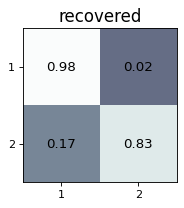

In [108]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
recovered_trans_mat_no_noise= np.exp(glmhmm_no_noise.transitions.log_Ps)
plt.imshow(recovered_trans_mat_no_noise, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat_no_noise.shape[0]):
    for j in range(recovered_trans_mat_no_noise.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat_no_noise[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)



Text(0, 0.5, 'observation class')

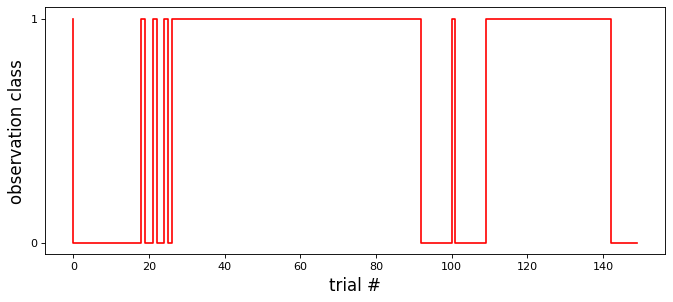

In [109]:
fig = plt.figure(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.step(range(150),responses_no_noise_array[range(150)], color = "red")
plt.yticks([0, 1])
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("observation class", fontsize = 15)

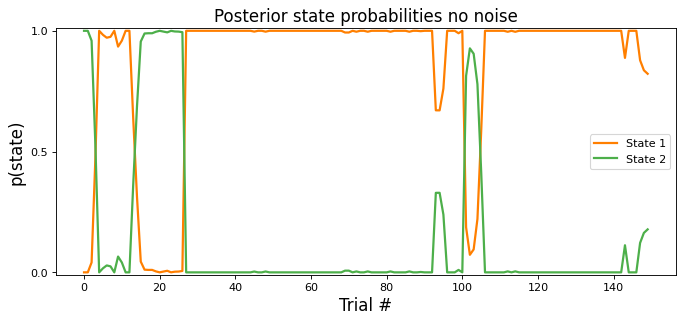

In [110]:
fig = plt.figure(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
posterior_probs_no_noise = glmhmm_no_noise.expected_states(data=responses_no_noise_array, input=inputs_array_no_noise)[0]
num_states = posterior_probs_no_noise.shape[1]  
for k in range(num_states):
    plt.plot(posterior_probs_no_noise[:, k], label="State " + str(k + 1), lw=2, color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize=10)
plt.xlabel("Trial #", fontsize=15)
plt.ylabel("p(state)", fontsize=15)
plt.title("Posterior state probabilities no noise", fontsize = 15)
plt.legend()
plt.show()

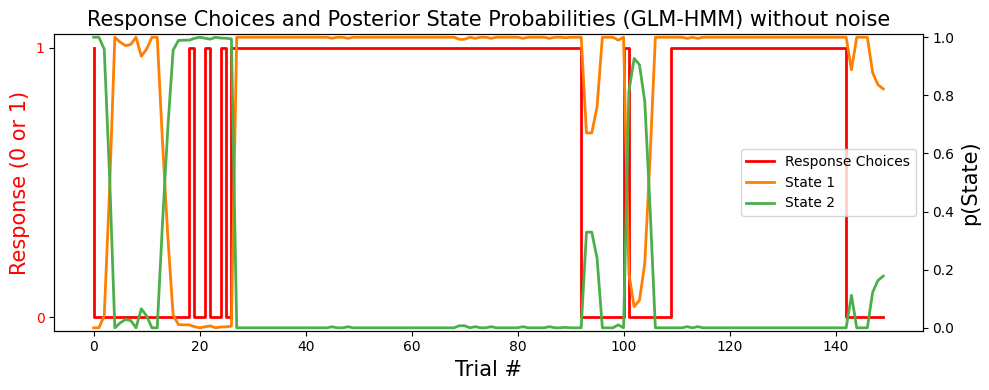

In [111]:
cols = ['#ff7f00', '#4daf4a', '#377eb8','#984ea3']
fig, ax1 = plt.subplots(figsize=(10, 4), facecolor='w', edgecolor='k')
ax1.step(range(len(responses_no_noise_array)), responses_no_noise_array, color="red", label="Response Choices", lw=2)
ax1.set_yticks([0, 1])
ax1.set_title("Response Choices and Posterior State Probabilities (GLM-HMM) without noise", fontsize=15)
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("Response (0 or 1)", fontsize=15, color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax2 = ax1.twinx()
for k in range(num_states):
    ax2.plot(range(len(responses_no_noise_array)), posterior_probs_no_noise[:, k], label="State " + str(k + 1), lw=2, color=cols[k])
ax2.set_ylim((-0.01, 1.01))
ax2.set_ylabel("p(State)", fontsize=15)
ax2.tick_params(axis='y')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2)
plt.tight_layout()
plt.show()


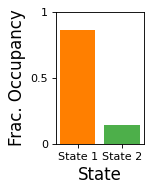

In [112]:
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#984ea3']
posterior_probs_concat_no_noise = np.vstack(posterior_probs_no_noise) 
state_max_posterior_no_noise = np.argmax(posterior_probs_concat_no_noise, axis=1)
_, state_occupancies_no_noise = np.unique(state_max_posterior_no_noise, return_counts=True)
state_occupancies_no_noise = state_occupancies_no_noise / np.sum(state_occupancies_no_noise)
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies_no_noise):
    plt.bar(z, occ, width=0.8, color=cols[z]) 
plt.ylim((0, 1))
plt.xticks([0, 1], ['State 1', 'State 2'], fontsize=10)  
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('State', fontsize=15)
plt.ylabel('Frac. Occupancy', fontsize=15)
plt.tight_layout()
plt.show()

In [113]:
#state_numeric_no_noise = [1 if state == "ENG" else 0 for state in saved_states_no_noise]
posterior_probs_no_noise = glmhmm_no_noise.expected_states(data=responses_no_noise_array, input=inputs_array_no_noise)[0]
predicted_states_no_noise = np.argmax(posterior_probs_no_noise, axis=1)
rmse_no_noise = np.sqrt(mean_squared_error(state_numeric_no_noise, predicted_states_no_noise))

print("RMSE (No Noise):", rmse_no_noise)


RMSE (No Noise): 0.3651483716701107


In [114]:
posterior_probs_no_noise.shape

(150, 2)

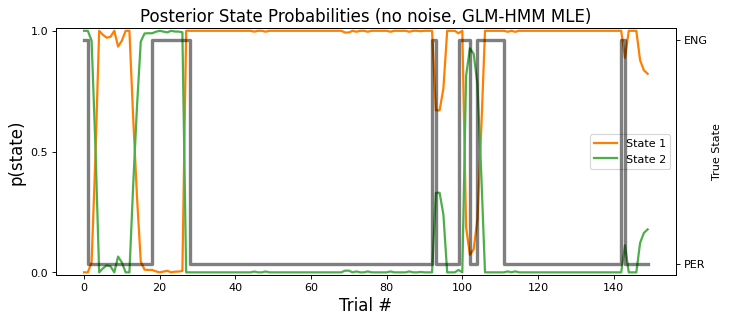

In [115]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
posterior_probs_no_noise = glmhmm_no_noise.expected_states(data=responses_no_noise_array, input=inputs_array_no_noise)[0]
num_states = posterior_probs_no_noise.shape[1]
for k in range(num_states):
    ax1.plot(posterior_probs_no_noise[:, k], label="State " + str(k + 1) , lw=2, color=cols[k])

ax1.set_ylim((-0.01, 1.01))
ax1.set_yticks([0, 0.5, 1])
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("p(state)", fontsize=15)
ax1.set_title("Posterior State Probabilities (no noise, GLM-HMM MLE)", fontsize=15)
ax1.legend()

ax2 = ax1.twinx()
ax2.step(range(len(state_numeric_no_noise)), state_numeric_no_noise, where='post', linewidth=3, color='black', alpha=0.5)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['PER', 'ENG'])
ax2.set_ylabel('True State')

plt.show()


## Fit GLM-HMM and perform recovery analysis: Maximum A Priori Estimation

In [117]:
npr.seed(0)
# Set the parameters of the GLM-HMM
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 8         # input dimensions

In [118]:
prior_means = [(0, 1), (0, 0)]  # Means for (kernel, prev_resp) for each state
prior_sigmas = [(0.01, 0.1), (10, 0.01)]  # Sigmas for (kernel, prev_resp) for each state
prior_alpha = 5
# Instantiate the GLM-HMM
map_glmhmm_no_noise = ssm.HMM(num_states, obs_dim, input_dim, 
             observations="ind_input_driven_obs", 
             observation_kwargs=dict(C=2, prior_means=prior_means, prior_sigmas=prior_sigmas), 
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0))

# Fit the model using EM with MAP estimation
fit_map_no_noise = map_glmhmm_no_noise.fit(responses_no_noise_array, inputs=inputs_array_no_noise, method="em", num_iters=1000, tolerance=1e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [119]:
map_glm_weights_state_no_noise=map_glmhmm_no_noise.observations.params
map_glm_weights_state_1_no_noise = map_glmhmm_no_noise.observations.params[0]  
map_glm_weights_state_2_no_noise = map_glmhmm_no_noise.observations.params[1] 

In [120]:
print(map_glm_weights_state_1_no_noise)
print(map_glm_weights_state_2_no_noise)


[[0.         0.         0.         0.         0.         0.
  0.         0.97510491]]
[[ 0.00100543 -0.0030805  -0.00091237 -0.00168632  0.00117207  0.00172355
   0.00180915  0.        ]]


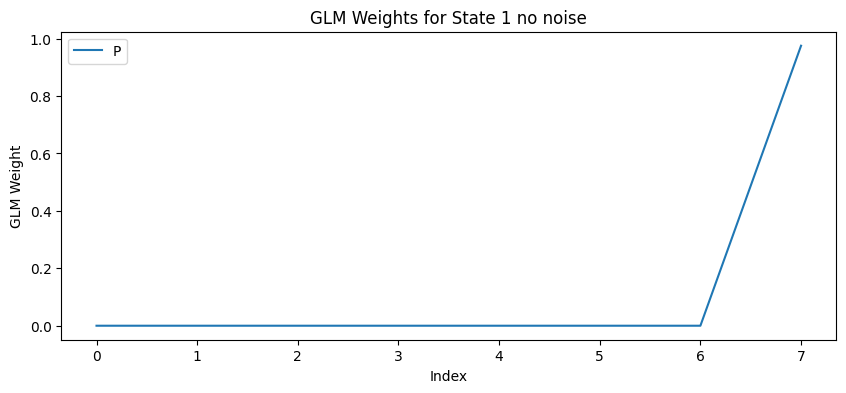

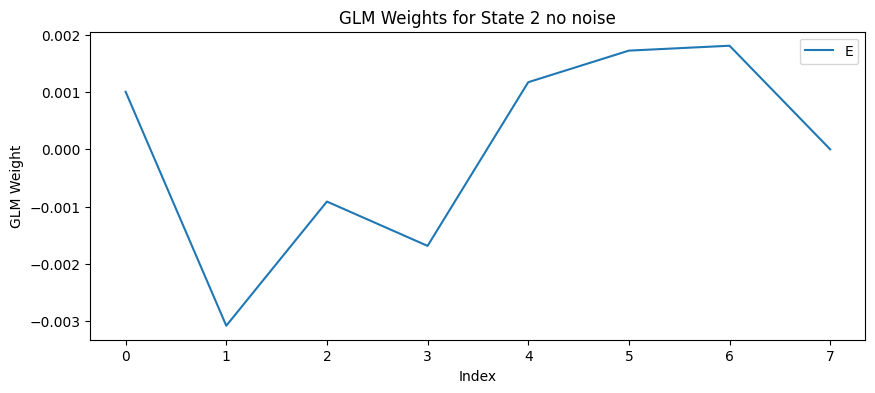

In [121]:
plt.figure(figsize=(10, 4))
for i in range(map_glm_weights_state_1_no_noise.shape[0]):
    plt.plot(map_glm_weights_state_1_no_noise[i][:], label=f'Row {i}')
#plt.plot(-2*obs_no_noise.kernel)
plt.xlabel('Index')
plt.ylabel('GLM Weight')
plt.title('GLM Weights for State 1 no noise')
plt.legend('PER')
plt.show()

plt.figure(figsize=(10, 4))
for i in range(map_glm_weights_state_2_no_noise.shape[0]):
    plt.plot(map_glm_weights_state_2_no_noise[i][:], label=f'Row {i}')
#plt.plot(-2*obs_no_noise.kernel)
plt.xlabel('Index')
plt.ylabel('GLM Weight')
plt.title('GLM Weights for State 2 no noise')
plt.legend('ENG')
plt.show()



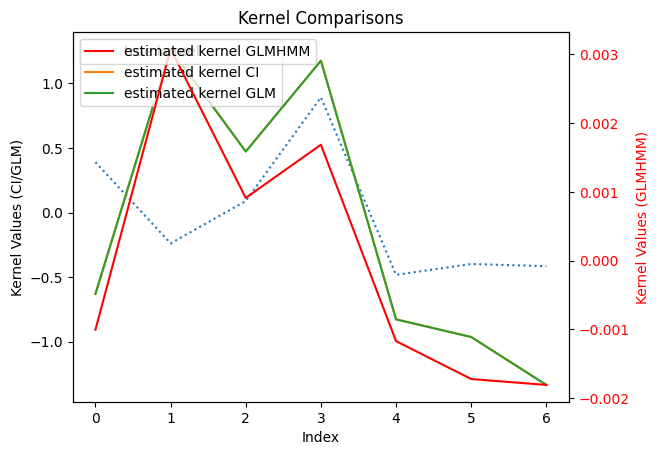

In [123]:
fig, ax1 = plt.subplots()

ax1.plot(obs.kernel, ':', label='true kernel')
ax1.plot(
    ClassificationImage.normalize_kernel(ClassificationImage.extract_single_kernel(responses_df)),
    label='estimated kernel CI'
)
ax1.plot(
    GLMKernel.normalize_kernel(ClassificationImage.extract_single_kernel(responses_df)),
    label='estimated kernel GLM'
)
ax1.set_xlabel("Index")
ax1.set_ylabel("Kernel Values (CI/GLM)")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(map_glm_weights_state_2_no_noise[i][:-1] * -1, label='estimated kernel GLMHMM', color='red')
ax2.set_ylabel("Kernel Values (GLMHMM)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax2.legend(loc='upper left')

plt.title("Kernel Comparisons")
plt.show()

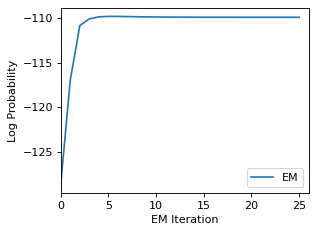

In [124]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_map_no_noise, label="EM")
#plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_map_no_noise))
plt.ylabel("Log Probability")
plt.show()



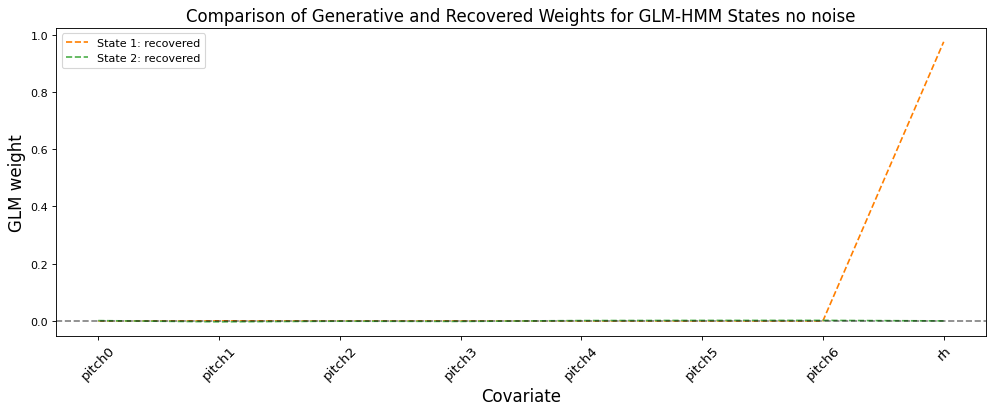

In [125]:
fig = plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8','#984ea3'] 
map_recovered_weights_no_noise = (map_glmhmm_no_noise.observations.params)
for k in range(num_states):
    plt.plot(range(input_dim), (map_recovered_weights_no_noise[k][0])[:], color=cols[k],
             lw=1.5, label=f"State {k+1}: recovered", linestyle='--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariate", fontsize=15)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.xticks(range(input_dim), ['pitch0', 'pitch1', 'pitch2', 'pitch3', 'pitch4', 'pitch5','pitch6','rh'], 
           fontsize=12, rotation=45)
plt.legend()
plt.title("Comparison of Generative and Recovered Weights for GLM-HMM States no noise", fontsize=15)
plt.show()



Text(0.5, 1.0, 'recovered')

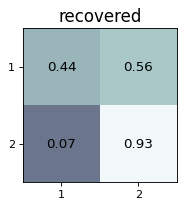

In [126]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
map_recovered_trans_mat_no_noise= np.exp(map_glmhmm_no_noise.transitions.log_Ps)
plt.imshow(map_recovered_trans_mat_no_noise, vmin=-0.8, vmax=1, cmap='bone')
for i in range(map_recovered_trans_mat_no_noise.shape[0]):
    for j in range(map_recovered_trans_mat_no_noise.shape[1]):
        text = plt.text(j, i, str(np.around(map_recovered_trans_mat_no_noise[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)



Text(0, 0.5, 'observation class')

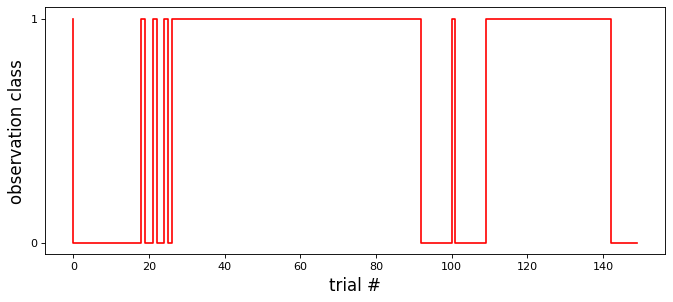

In [127]:
fig = plt.figure(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.step(range(150),responses_no_noise_array[range(150)], color = "red")
plt.yticks([0, 1])
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("observation class", fontsize = 15)



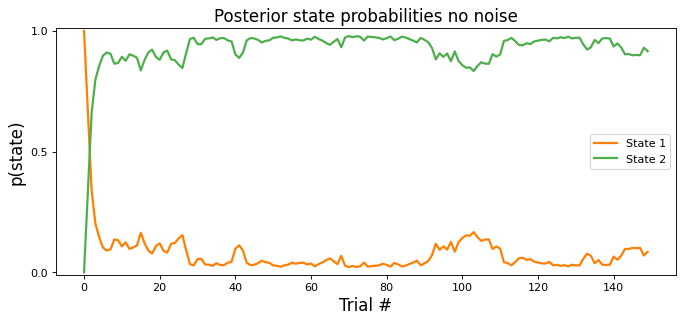

In [128]:
fig = plt.figure(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
posterior_probs_map_no_noise = map_glmhmm_no_noise.expected_states(data=responses_no_noise_array, input=inputs_array_no_noise)[0]
num_states = posterior_probs_map_no_noise.shape[1]  
for k in range(num_states):
    plt.plot(posterior_probs_map_no_noise[:, k], label="State " + str(k + 1), lw=2, color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize=10)
plt.xlabel("Trial #", fontsize=15)
plt.ylabel("p(state)", fontsize=15)
plt.title("Posterior state probabilities no noise", fontsize = 15)
plt.legend()
plt.show()


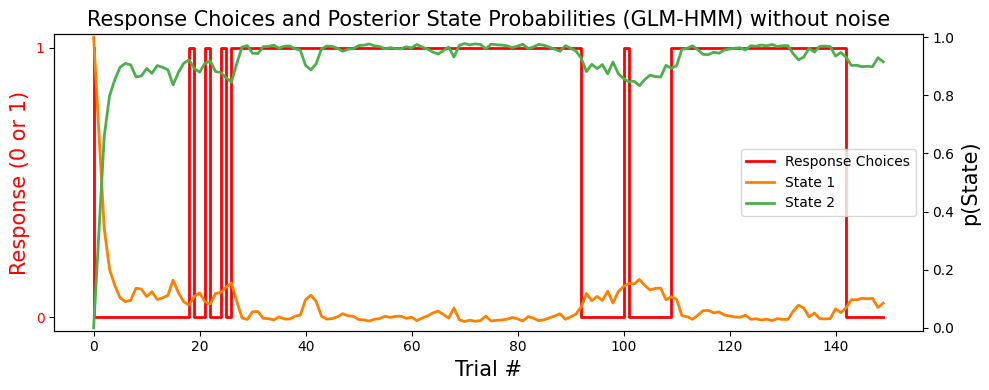

In [129]:
cols = ['#ff7f00', '#4daf4a', '#377eb8','#984ea3']
fig, ax1 = plt.subplots(figsize=(10, 4), facecolor='w', edgecolor='k')
ax1.step(range(len(responses_no_noise_array)), responses_no_noise_array, color="red", label="Response Choices", lw=2)
ax1.set_yticks([0, 1])
ax1.set_title("Response Choices and Posterior State Probabilities (GLM-HMM) without noise", fontsize=15)
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("Response (0 or 1)", fontsize=15, color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax2 = ax1.twinx()
for k in range(num_states):
    ax2.plot(range(len(responses_no_noise_array)), posterior_probs_map_no_noise[:, k], label="State " + str(k + 1), lw=2, color=cols[k])
ax2.set_ylim((-0.01, 1.01))
ax2.set_ylabel("p(State)", fontsize=15)
ax2.tick_params(axis='y')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2)
plt.tight_layout()
plt.show()



In [130]:
#state_numeric_no_noise = [1 if state == "ENG" else 0 for state in saved_states_no_noise]
posterior_probs_no_noise_map = map_glmhmm_no_noise.expected_states(data=responses_no_noise_array, input=inputs_array_no_noise)[0]
predicted_states_no_noise_map= np.argmax(posterior_probs_no_noise_map, axis=1)
rmse_no_noise_map = np.sqrt(mean_squared_error(state_numeric_no_noise, predicted_states_no_noise_map))
#state_numeric_with_noise_map = [1 if state == "ENG" else 0 for state in saved_states_with_noise]
print("RMSE MAP(No Noise):", rmse_no_noise_map)


RMSE MAP(No Noise): 0.9201449161228175


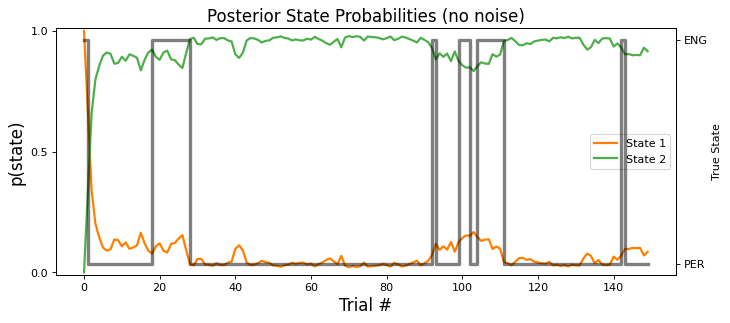

In [131]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
posterior_probs_map_no_noise = map_glmhmm_no_noise.expected_states(data=responses_no_noise_array, input=inputs_array_no_noise)[0]
num_states = posterior_probs_map_no_noise.shape[1]
for k in range(num_states):
    ax1.plot(posterior_probs_map_no_noise[:, k], label="State " + str(k + 1), lw=2, color=cols[k])

ax1.set_ylim((-0.01, 1.01))
ax1.set_yticks([0, 0.5, 1])
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("p(state)", fontsize=15)
ax1.set_title("Posterior State Probabilities (no noise)", fontsize=15)
ax1.legend()

ax2 = ax1.twinx()
ax2.step(range(len(state_numeric_no_noise)), state_numeric_no_noise, where='post', linewidth=3, color='black', alpha=0.5)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['PER', 'ENG'])
ax2.set_ylabel('True State')

plt.show()



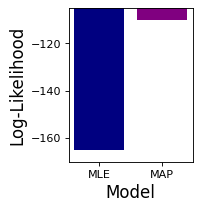

In [132]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')

# Use the last log-likelihood value from each fit
final_fit_ll_no_noise = fit_ll_no_noise[-1]
final_fit_map_no_noise = fit_map_no_noise[-1]

loglikelihood_vals_no_noise = [final_fit_ll_no_noise, final_fit_map_no_noise]
colors = ['Navy', 'Purple']

for z, occ in enumerate(loglikelihood_vals_no_noise):
    plt.bar(z, occ, width=0.8, color=colors[z])

# Set y-axis limits with some padding
plt.ylim((min(loglikelihood_vals_no_noise) - 5, max(loglikelihood_vals_no_noise) + 5))
plt.xticks([0, 1], ['MLE', 'MAP'], fontsize=10)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Log-Likelihood', fontsize=15)
plt.show()

## GLM HMM priors grid search 

Best RMSE: 0.1
Best Parameters:
  Means: [(0, 1), (0, 0)]
  Sigmas: [(0.01, 1.2575), (2.505, 0.01)]
  Alpha: 1.526315789473684


  0%|          | 0/500 [00:00<?, ?it/s]

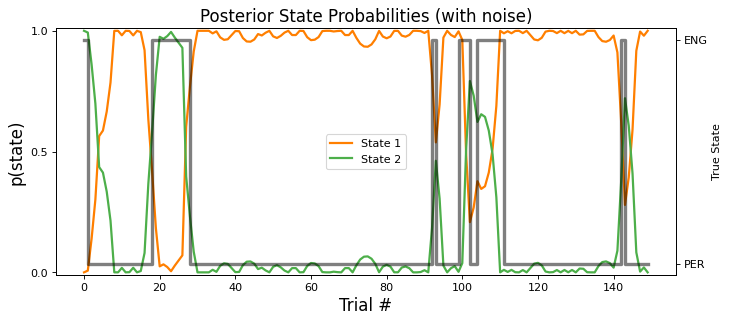

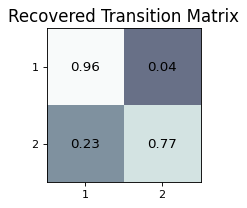

In [ ]:
# Set the parameters of the GLM-HMM
npr.seed(0)
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 8         # input dimensions

# Define reduced ranges for prior means, sigmas, and alpha to speed up the grid search
mean_range_1 = [1]#np.linspace(-1, 1, 3)  # Reduced range for first state mean
mean_range_2 = [0]#np.linspace(-1, 1, 3)  # Reduced range for second state mean
sigma_range_1 = np.linspace(0.01, 5, 5)  # Reduced range for first state sigma
sigma_range_2 = np.linspace(0.01, 5, 5)  # Reduced range for second state sigma
alpha_range = np.linspace(1, 2, 20)  # Reduced range for alpha values

best_rmse = float('inf')
best_params = None

# Function to fit the model and calculate RMSE
def fit_glmhmm(mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value):
    # Ensure different values for mean_1 and mean_2, sigma_1 and sigma_2
    if mean_value_1 == mean_value_2 or sigma_value_1 == sigma_value_2:
        return float('inf'), None

    prior_means = [(0, mean_value_1), (mean_value_2, 0)]
    prior_sigmas = [(0.01, sigma_value_1), (sigma_value_2, 0.01)]
    prior_alpha = alpha_value

    # Instantiate the GLM-HMM
    map_glmhmm_no_noise = ssm.HMM(
        num_states, obs_dim, input_dim,
        observations="ind_input_driven_obs",
        observation_kwargs=dict(C=2, prior_means=prior_means, prior_sigmas=prior_sigmas),
        transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
    )

    # Fit the model using EM with MAP estimation
    fit_map_no_noise = map_glmhmm_no_noise.fit(
        responses_no_noise_array, inputs=inputs_array_no_noise, method="em", num_iters=500, tolerance=1e-4
    )

    # Extract predicted states and calculate RMSE
    posterior_probs_map_no_noise = map_glmhmm_no_noise.expected_states(
        data=responses_no_noise_array, input=inputs_array_no_noise
    )[0]
    predicted_states_no_noise_map = np.argmax(posterior_probs_map_no_noise, axis=1)

    # Convert saved states to numerical format (assuming saved_states_with_noise are available)
    state_numeric_no_noise_map = [1 if state == "ENG" else 0 for state in states]
    #rmse = -fit_map_no_noise[-1]
    rmse = np.mean(predicted_states_no_noise_map != state_numeric_no_noise_map)
    #rmse = np.sqrt(mean_squared_error(state_numeric_no_noise_map, predicted_states_no_noise_map))

    return rmse, (prior_means, prior_sigmas, prior_alpha)

# Run the grid search in parallel
results = Parallel(n_jobs=-1)(
    delayed(fit_glmhmm)(mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value)
    for mean_value_1 in mean_range_1
    for mean_value_2 in mean_range_2
    for sigma_value_1 in sigma_range_1
    for sigma_value_2 in sigma_range_2
    for alpha_value in alpha_range
)

# Find the best parameters and RMSE
for rmse, params in results:
    if rmse < best_rmse and params is not None:
        best_rmse = rmse
        best_params = params

print("Best RMSE:", best_rmse)
print("Best Parameters:")
print("  Means:", best_params[0])
print("  Sigmas:", best_params[1])
print("  Alpha:", best_params[2])

# Posterior probabilities for each trial with the best parameters
prior_means, prior_sigmas, prior_alpha = best_params
map_glmhmm_no_noise = ssm.HMM(
    num_states, obs_dim, input_dim,
    observations="ind_input_driven_obs",
    observation_kwargs=dict(C=2, prior_means=prior_means, prior_sigmas=prior_sigmas),
    transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
)

# Fit the model using EM with MAP estimation
fit_map_no_noise = map_glmhmm_no_noise.fit(
    responses_no_noise_array, inputs=inputs_array_no_noise, method="em", num_iters=500, tolerance=1e-4
)

# Extract GLM weights after fitting
map_glm_weights_state_no_noise = map_glmhmm_no_noise.observations.params

# Posterior probabilities for each trial
posterior_probs_map_no_noise = map_glmhmm_no_noise.expected_states(
    data=responses_no_noise_array, input=inputs_array_no_noise
)[0]

# Plot posterior state probabilities for each trial (with noise)
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#984ea3']
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')

num_states = posterior_probs_map_no_noise.shape[1]
for k in range(num_states):
    ax1.plot(posterior_probs_map_no_noise[:, k], label="State " + str(k + 1), lw=2, color=cols[k])

ax1.set_ylim((-0.01, 1.01))
ax1.set_yticks([0, 0.5, 1])
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("p(state)", fontsize=15)
ax1.set_title("Posterior State Probabilities (with noise)", fontsize=15)
ax1.legend()

# Plot true states (with noise) on the secondary y-axis
ax2 = ax1.twinx()
state_numeric_no_noise_map = [1 if state == "ENG" else 0 for state in states]
ax2.step(range(len(state_numeric_no_noise_map)), state_numeric_no_noise_map, where='post', linewidth=3, color='black', alpha=0.5)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['PER', 'ENG'])
ax2.set_ylabel('True State')

plt.show()

# Plot the recovered transition matrix for the best parameters
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
map_recovered_trans_mat_no_noise = np.exp(map_glmhmm_no_noise.transitions.log_Ps)
plt.imshow(map_recovered_trans_mat_no_noise, vmin=-0.8, vmax=1, cmap='bone')
for i in range(map_recovered_trans_mat_no_noise.shape[0]):
    for j in range(map_recovered_trans_mat_no_noise.shape[1]):
        text = plt.text(j, i, str(np.around(map_recovered_trans_mat_no_noise[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("Recovered Transition Matrix", fontsize=15)
plt.show()

## BO GLM-HMM

In [133]:
import numpy as np
import pickle
from skopt import gp_minimize
from skopt.space import Real
import pandas as pd
import ssm  # Ensure ssm library is properly imported

# Define parameters for GLM-HMM
num_states = 2        # Number of discrete states
obs_dim = 1           # Number of observed dimensions
num_categories = 2    # Number of categories for output
input_dim = 8         # Input dimensions (7 stimulus differences + 1 choice history)

# Function to fit the model and calculate RMSE and residuals
def fit_glmhmm(params, responses, inputs, saved_states):
    mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value = params

    # Define priors
    prior_means = [(0, mean_value_1), (mean_value_2, 0)]
    prior_sigmas = [(0.01, sigma_value_1), (sigma_value_2, 0.01)]
    prior_alpha = alpha_value

    # Instantiate the GLM-HMM
    map_glmhmm = ssm.HMM(
        num_states, obs_dim, input_dim,
        observations="ind_input_driven_obs",
        observation_kwargs=dict(C=num_categories, prior_means=prior_means, prior_sigmas=prior_sigmas),
        transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
    )

    # Fit the model using EM with MAP estimation
    map_glmhmm.fit(responses, inputs=inputs, method="em", num_iters=200, tolerance=1e-3)

    # Extract predicted states and calculate RMSE
    posterior_probs = map_glmhmm.expected_states(data=responses, input=inputs)[0]
    predicted_states = np.argmax(posterior_probs, axis=1)

    # Convert saved states to numerical format
    state_numeric = [1 if state == "ENG" else 0 for state in saved_states]

    # Calculate RMSE for all states
    rmse_total = np.mean(predicted_states != state_numeric)

    # Calculate mismatch rate separately for PER and ENG states
    per_indices = [i for i, state in enumerate(state_numeric) if state == 0]
    rmse_per = np.mean(predicted_states[per_indices] != np.array(state_numeric)[per_indices]) if per_indices else np.nan
    eng_indices = [i for i, state in enumerate(state_numeric) if state == 1]
    rmse_eng = np.mean(predicted_states[eng_indices] != np.array(state_numeric)[eng_indices]) if eng_indices else np.nan

    # Calculate the log likelihood of the fitted model
    log_likelihood = map_glmhmm.log_likelihood(responses, inputs=inputs)

    return (
        rmse_total, rmse_per, rmse_eng, log_likelihood, 
        (prior_means, prior_sigmas, prior_alpha), 
        predicted_states, posterior_probs, 
        map_glmhmm.observations.params[0], map_glmhmm.observations.params[1], 
        np.exp(map_glmhmm.transitions.log_Ps)
    )

# Define the optimization space
space = [
    Real(0.0, 2.0, name='mean_value_1'),
    Real(0.0, 2.0, name='mean_value_2'),
    Real(1.0, 5.0, name='sigma_value_1'),
    Real(1.0, 5.0, name='sigma_value_2'),
    Real(1.0, 3.0, name='alpha_value')
]

# Optimization function for Bayesian Optimization
def objective(params):
    rmse_total, *_ = fit_glmhmm(params, responses_array, inputs_with_history, saved_states)
    return rmse_total

# Prepare results storage
glm_hmm_results2 = []
posterior_probabilities_list = []
observed_states_list = []
glm_weights_list = []

# Replace `sim_combined_df` with inputs and responses directly
responses_array = responses_no_noise_array# Example response array
inputs_with_history =inputs_array_no_noise  # Example inputs (stimulus differences + choice history)
saved_states = states

# Run Bayesian optimization for the given input
result = gp_minimize(objective, space, n_calls=30, random_state=42)

# Get the best parameters and fit the model again to extract details
best_params = result.x
best_rmse_total, best_rmse_per, best_rmse_eng, log_likelihood, best_params_full, best_states, \
best_posterior_probs, best_glm_weights_state_1, best_glm_weights_state_2, transitions_log_ps = fit_glmhmm(
    best_params, responses_array, inputs_with_history, saved_states
)

# Append posterior probabilities, observed states, and GLM weights for plotting
posterior_probabilities_list.append(best_posterior_probs)
observed_states_list.append(saved_states)
glm_weights_list.append((best_glm_weights_state_1, best_glm_weights_state_2))

# Save results
glm_hmm_results2.append({
    'best_rmse_total': best_rmse_total,
    'best_rmse_per': best_rmse_per,
    'best_rmse_eng': best_rmse_eng,
    'log_likelihood': log_likelihood,
    'best_prior_alpha': best_params_full[2],
    'best_prior_sigma_1': best_params_full[1][0][1],
    'best_prior_sigma_2': best_params_full[1][1][0],
    'best_mean_value_1': best_params_full[0][0][1],
    'best_mean_value_2': best_params_full[1][1][0],
    'best_posterior_probs': best_posterior_probs,
    'glm_weights_state_1': best_glm_weights_state_1,
    'glm_weights_state_2': best_glm_weights_state_2,
    'transitions_log_ps': transitions_log_ps,
})

# Save intermediate results
with open('intermediate_glm_hmm_results.pkl', 'wb') as f:
    pickle.dump(glm_hmm_results2, f)

# Convert results to DataFrame
results_df_new2 = pd.DataFrame(glm_hmm_results2)
print(results_df_new2)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   best_rmse_total  best_rmse_per  best_rmse_eng  log_likelihood  \
0         0.133333       0.055118       0.565217      -47.421193   

   best_prior_alpha  best_prior_sigma_1  best_prior_sigma_2  \
0          2.578171                 1.0            1.614768   

   best_mean_value_1  best_mean_value_2  \
0           0.899509           1.614768   

                                best_posterior_probs  \
0  [[8.591295209313567e-10, 0.9999999991408686], ...   

                                 glm_weights_state_1  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.910603...   

                                 glm_weights_state_2  \
0  [[0.05257571038906247, -0.007440352521966782, ...   

                                  transitions_log_ps  
0  [[0.9317124161978354, 0.06828758380216476], [0...  


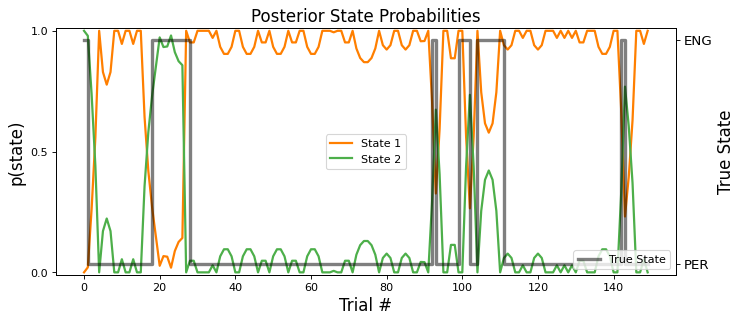

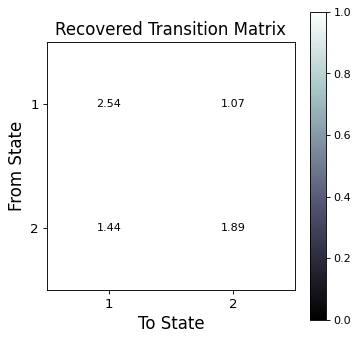

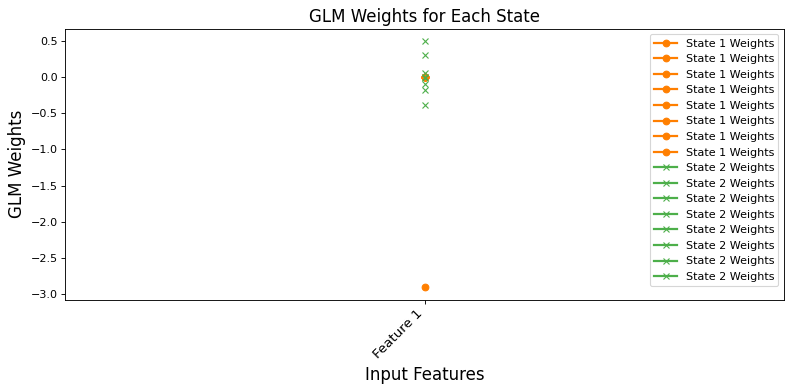

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Visualize the posterior state probabilities
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')

# Plot posterior probabilities for each state
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#984ea3']
num_states = best_posterior_probs.shape[1]

for k in range(num_states):
    ax1.plot(
        best_posterior_probs[:, k],
        label=f"State {k + 1}",
        lw=2,
        color=cols[k]
    )

# Format the primary y-axis
ax1.set_ylim((-0.01, 1.01))
ax1.set_yticks([0, 0.5, 1])
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("p(state)", fontsize=15)
ax1.set_title("Posterior State Probabilities", fontsize=15)
ax1.legend()

# Plot true states on the secondary y-axis
ax2 = ax1.twinx()
true_states_numeric = [1 if state == "ENG" else 0 for state in saved_states]
ax2.step(
    range(len(true_states_numeric)),
    true_states_numeric,
    where='post',
    linewidth=3,
    color='black',
    alpha=0.5,
    label="True State"
)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['PER', 'ENG'], fontsize=12)
ax2.set_ylabel("True State", fontsize=15)
ax2.legend(loc="lower right")

plt.show()

# Visualize the recovered transition matrix
fig, ax = plt.subplots(figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
recovered_trans_mat = np.exp(transitions_log_ps)

# Plot the transition matrix
im = ax.imshow(recovered_trans_mat, vmin=0, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = ax.text(
            j, i,
            f"{recovered_trans_mat[i, j]:.2f}",
            ha="center",
            va="center",
            color="black"
        )

# Format the axes
ax.set_xticks(range(num_states))
ax.set_xticklabels([str(k + 1) for k in range(num_states)], fontsize=12)
ax.set_yticks(range(num_states))
ax.set_yticklabels([str(k + 1) for k in range(num_states)], fontsize=12)
ax.set_xlabel("To State", fontsize=15)
ax.set_ylabel("From State", fontsize=15)
ax.set_title("Recovered Transition Matrix", fontsize=15)

plt.colorbar(im, ax=ax)
plt.show()

# Visualize GLM weights for both states
fig, ax = plt.subplots(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

# Plot weights for state 1 and state 2
x = np.arange(len(best_glm_weights_state_1))
ax.plot(
    x,
    best_glm_weights_state_1,
    label="State 1 Weights",
    marker="o",
    color="#ff7f00",
    lw=2
)
ax.plot(
    x,
    best_glm_weights_state_2,
    label="State 2 Weights",
    marker="x",
    color="#4daf4a",
    lw=2
)

# Format the plot
ax.set_xticks(x)
ax.set_xticklabels([f"Feature {i+1}" for i in x], rotation=45, ha="right", fontsize=12)
ax.set_xlabel("Input Features", fontsize=15)
ax.set_ylabel("GLM Weights", fontsize=15)
ax.set_title("GLM Weights for Each State", fontsize=15)
ax.legend()

plt.tight_layout()
plt.show()


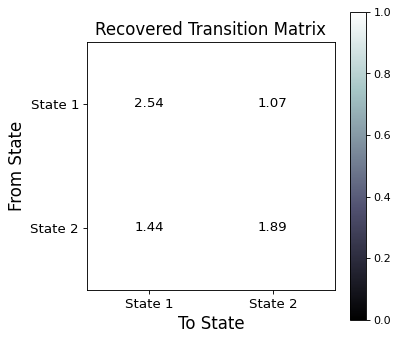

In [137]:
#  Visualize the recovered transition matrix
fig, ax = plt.subplots(figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')

# Transition matrix (log probabilities converted to probabilities)
recovered_trans_mat = np.exp(transitions_log_ps)

# Plot the heatmap
im = ax.imshow(recovered_trans_mat, vmin=0, vmax=1, cmap='bone')

# Add text annotations
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        ax.text(j, i, f"{recovered_trans_mat[i, j]:.2f}", ha="center", va="center", color="black", fontsize=12)

# Set axis labels and titles
ax.set_xticks(range(num_states))
ax.set_xticklabels([f"State {k+1}" for k in range(num_states)], fontsize=12)
ax.set_yticks(range(num_states))
ax.set_yticklabels([f"State {k+1}" for k in range(num_states)], fontsize=12)
ax.set_xlabel("To State", fontsize=15)
ax.set_ylabel("From State", fontsize=15)
ax.set_title("Recovered Transition Matrix", fontsize=15)

# Add colorbar
plt.colorbar(im, ax=ax)
plt.show()

In [138]:
print(results_df_new2)

   best_rmse_total  best_rmse_per  best_rmse_eng  log_likelihood  \
0         0.133333       0.055118       0.565217      -47.421193   

   best_prior_alpha  best_prior_sigma_1  best_prior_sigma_2  \
0          2.578171                 1.0            1.614768   

   best_mean_value_1  best_mean_value_2  \
0           0.899509           1.614768   

                                best_posterior_probs  \
0  [[8.591295209313567e-10, 0.9999999991408686], ...   

                                 glm_weights_state_1  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.910603...   

                                 glm_weights_state_2  \
0  [[0.05257571038906247, -0.007440352521966782, ...   

                                  transitions_log_ps  
0  [[0.9317124161978354, 0.06828758380216476], [0...  


In [134]:
with open('intermediate_glm_hmm_results.pkl', 'rb') as f:
    glm_hmm_results2 = pickle.load(f)

# Now glm_hmm_results2 contains the data you saved
results_df_new2 = pd.DataFrame(glm_hmm_results2)
results_df_new2


,best_rmse_total,best_rmse_per,best_rmse_eng,log_likelihood,best_prior_alpha,best_prior_sigma_1,best_prior_sigma_2,best_mean_value_1,best_mean_value_2,best_posterior_probs,glm_weights_state_1,glm_weights_state_2,transitions_log_ps
0,0.133333,0.055118,0.565217,-47.421193,2.578171,1.0,1.614768,0.899509,1.614768,"[[8.591295209313567e-10, 0.9999999991408686], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.910603...","[[0.05257571038906247, -0.007440352521966782, ...","[[0.9317124161978354, 0.06828758380216476], [0..."


In [ ]:
mean_values = {  # Replace with your calculated mean
    'sigma_value_1': mean_median_df2.loc['best_prior_sigma_1', 'Mean'],  # Replace with your calculated mean
    'sigma_value_2': mean_median_df2.loc['best_prior_sigma_2', 'Mean'],  # Replace with your calculated mean
    'alpha_value': mean_median_df2.loc['best_prior_alpha', 'Mean'],
     'mean_value_1' : mean_median_df2.loc['best_mean_value_1', 'Mean'],
    'mean_value_2': mean_median_df2.loc['best_mean_value_2', 'Mean']
}
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 8         # input dimensions

# Function to fit the model and calculate RMSE and residuals
def fit_glmhmm(params, responses, inputs, saved_states):
    mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value = params

    prior_means = [(0, mean_value_1), (mean_value_2, 0)]
    prior_sigmas = [(0.01, sigma_value_1), (sigma_value_2, 0.01)]
    prior_alpha = alpha_value

    # Instantiate the GLM-HMM
    map_glmhmm = ssm.HMM(
        num_states, obs_dim, input_dim,
        observations="ind_input_driven_obs",
        observation_kwargs=dict(C=num_categories, prior_means=prior_means, prior_sigmas=prior_sigmas),
        transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
    )

    # Fit the model using EM with MAP estimation
    map_glmhmm.fit(responses, inputs=inputs, method="em", num_iters=200, tolerance=1e-3)

    # Extract predicted states and calculate RMSE
    posterior_probs = map_glmhmm.expected_states(data=responses, input=inputs)[0]
    predicted_states = np.argmax(posterior_probs, axis=1)

    # Calculate predicted responses and residuals
    predicted_responses = np.array([
        np.dot(inputs[i], map_glmhmm.observations.params[predicted_states[i]].reshape(-1))
        for i in range(len(responses))
    ])
    residuals = responses.flatten() - predicted_responses  # Flatten responses to match predicted responses shape

    # Convert saved states to numerical format (assuming saved_states are available)
    state_numeric = [1 if state == "ENG" else 0 for state in saved_states]
    rmse_total = np.mean(predicted_states != state_numeric)

# Calculate mismatch rate separately for PER and ENG states
# PER (state 0)
    per_indices = [i for i, state in enumerate(state_numeric) if state == 0]
    if len(per_indices) > 0:
        rmse_per = np.mean(predicted_states[per_indices] != np.array(state_numeric)[per_indices])
    else:
        rmse_per = np.nan  # No PER trials to calculate mismatch rate for

# ENG (state 1)
    eng_indices = [i for i, state in enumerate(state_numeric) if state == 1]
    if len(eng_indices) > 0:
        rmse_eng = np.mean(predicted_states[eng_indices] != np.array(state_numeric)[eng_indices])
    else:
        rmse_eng = np.nan  # No ENG trials to calculate mismatch rate for

    # Calculate the log likelihood of the fitted model
    log_likelihood = map_glmhmm.log_likelihood(responses, inputs=inputs)

    return rmse_total, rmse_per, rmse_eng, log_likelihood, (prior_means, prior_sigmas, prior_alpha), predicted_states, posterior_probs, \
           map_glmhmm.observations.params[0], map_glmhmm.observations.params[1], \
           np.exp(map_glmhmm.transitions.log_Ps), residuals

# Iterate over each simulation result in sim_combined_df
glm_hmm_results_mean = []
posterior_probabilities_list_mean = []
observed_states_list_mean = []
glm_weights_list_mean = []

# Use fixed parameters (mean values) for each observer
for idx in range(len(sim_combined_df)):
    responses = responses_list[idx]
    inputs = inputs_list[idx]
    saved_states = saved_states_list[idx]

    # Set the fixed parameters as a tuple
    fixed_params = (
        mean_values['mean_value_1'],
        mean_values['mean_value_2'],
        mean_values['sigma_value_1'],
        mean_values['sigma_value_2'],
        mean_values['alpha_value']
    )

    # Fit the model with the fixed parameters and extract details
    best_rmse_total, best_rmse_per, best_rmse_eng, log_likelihood,best_params_full, best_states, best_posterior_probs, best_glm_weights_state_1, \
    best_glm_weights_state_2, transitions_log_ps, residuals = fit_glmhmm(
        fixed_params, responses, inputs, saved_states
    )

    # Append posterior probabilities, observed states, and GLM weights for plotting
    posterior_probabilities_list_mean.append(best_posterior_probs)
    observed_states_list_mean.append(saved_states)
    glm_weights_list_mean.append((best_glm_weights_state_1, best_glm_weights_state_2))

    # Append the results to the global list, including residuals
    glm_hmm_results_mean.append({
        'simulation_index': idx,
        'best_rmse_total': best_rmse_total,
        'best_rmse_per': best_rmse_per,
        'best_rmse_eng': best_rmse_eng,
        'log_likelihood': log_likelihood,
        'best_prior_alpha': best_params_full[2],
        'best_mean_value_1': best_params[0],  
        'best_mean_value_2': best_params[1],
        'best_prior_sigma_1': best_params_full[1][0][1],
        'best_prior_sigma_2': best_params_full[1][1][0],
        'best_posterior_probs': best_posterior_probs,
        'glm_weights_state_1': best_glm_weights_state_1,
        'glm_weights_state_2': best_glm_weights_state_2,
        'transitions_log_ps': transitions_log_ps
        #'residuals': residuals  # Store residuals here
    })

    # Save intermediate results to a pickle file
    with open('intermediate_glm_hmm_results_mean_params.pkl', 'wb') as f:
        pickle.dump(glm_hmm_results_mean, f)

# Convert results to DataFrame
results_df_mean_params = pd.DataFrame(glm_hmm_results_mean)

In [ ]:
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 8         # input dimensions

best_rmse = float('inf')
best_params = None

# Function to fit the model and calculate RMSE and residuals
def fit_glmhmm(params, responses, inputs, saved_states):
    mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value = params

    prior_means = [(0, mean_value_1), (mean_value_2, 0)]
    prior_sigmas = [(0.01, sigma_value_1), (sigma_value_2, 0.01)]
    prior_alpha = alpha_value

    # Instantiate the GLM-HMM
    map_glmhmm = ssm.HMM(
        num_states, obs_dim, input_dim,
        observations="ind_input_driven_obs",
        observation_kwargs=dict(C=num_categories, prior_means=prior_means, prior_sigmas=prior_sigmas),
        transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
    )

    # Fit the model using EM with MAP estimation
    map_glmhmm.fit(responses, inputs=inputs, method="em", num_iters=200, tolerance=1e-3)

    # Extract predicted states and calculate RMSE
    posterior_probs = map_glmhmm.expected_states(data=responses, input=inputs)[0]
    predicted_states = np.argmax(posterior_probs, axis=1)

    # Convert saved states to numerical format (assuming saved_states are available)
    state_numeric = [1 if state == "ENG" else 0 for state in saved_states]
    
    # Calculate RMSE for all states
    # Calculate total mismatch rate (binary classification error rate)
    rmse_total = np.mean(predicted_states != state_numeric)

# Calculate mismatch rate separately for PER and ENG states
# PER (state 0)
    per_indices = [i for i, state in enumerate(state_numeric) if state == 0]
    if len(per_indices) > 0:
        rmse_per = np.mean(predicted_states[per_indices] != np.array(state_numeric)[per_indices])
    else:
        rmse_per = np.nan  # No PER trials to calculate mismatch rate for

# ENG (state 1)
    eng_indices = [i for i, state in enumerate(state_numeric) if state == 1]
    if len(eng_indices) > 0:
        rmse_eng = np.mean(predicted_states[eng_indices] != np.array(state_numeric)[eng_indices])
    else:
        rmse_eng = np.nan  # No ENG trials to calculate mismatch rate for

    # Calculate the log likelihood of the fitted model
    log_likelihood = map_glmhmm.log_likelihood(responses, inputs=inputs)

    return rmse_total, rmse_per, rmse_eng, log_likelihood, (prior_means, prior_sigmas, prior_alpha), \
           predicted_states, posterior_probs, \
           map_glmhmm.observations.params[0], map_glmhmm.observations.params[1], \
           np.exp(map_glmhmm.transitions.log_Ps)

# Define the optimization space
space = [
    Real(0.0, 2.0, name='mean_value_1'),
    Real(0.0, 2.0, name='mean_value_2'),
    Real(1.0, 5.0, name='sigma_value_1'),
    Real(1.0, 5.0, name='sigma_value_2'),
    Real(1.0, 3.0, name='alpha_value')
]

# Optimization function for Bayesian Optimization
def objective(params):
    rmse_total, *_ = fit_glmhmm(params, responses, inputs, saved_states)
    return rmse_total

# Iterate over each simulation result in sim_combined_df
glm_hmm_results2 = []
posterior_probabilities_list = []
observed_states_list = []
glm_weights_list = []

for idx in range(len(sim_combined_df)):
    responses = responses_list[idx]
    inputs = inputs_list[idx]
    saved_states = states[idx]

    # Run Bayesian optimization to find the best parameters
    result = gp_minimize(objective, space, n_calls=30, random_state=42)

    # Get the best parameters and fit the model again to extract details
    best_params = result.x
    best_rmse_total, best_rmse_per, best_rmse_eng, log_likelihood, best_params_full, best_states, \
    best_posterior_probs, best_glm_weights_state_1, best_glm_weights_state_2, transitions_log_ps = fit_glmhmm(
        best_params, responses, inputs, saved_states
    )

    # Append posterior probabilities, observed states, and GLM weights for plotting
    posterior_probabilities_list.append(best_posterior_probs)
    observed_states_list.append(saved_states)
    glm_weights_list.append((best_glm_weights_state_1, best_glm_weights_state_2))

    # Append the results to the global list, including RMSE for each state and log likelihood
    glm_hmm_results2.append({
        'simulation_index': idx,
        'best_rmse_total': best_rmse_total,
        'best_rmse_per': best_rmse_per,
        'best_rmse_eng': best_rmse_eng,
        'log_likelihood': log_likelihood,
        'best_prior_alpha': best_params_full[2],
        'best_prior_sigma_1': best_params_full[1][0][1],
        'best_prior_sigma_2': best_params_full[1][1][0],
        'best_mean_value_1': best_params_full[0][0][1],  
        'best_mean_value_2': best_params_full[1][1][0],
        'best_posterior_probs': best_posterior_probs,
        'glm_weights_state_1': best_glm_weights_state_1,
        'glm_weights_state_2': best_glm_weights_state_2,
        'transitions_log_ps': transitions_log_ps,
    })

    # Save intermediate results to a pickle file
    with open('intermediate_glm_hmm_results4.pkl', 'wb') as f:
        pickle.dump(glm_hmm_results2, f)

# Convert results to DataFrame
results_df_new2 = pd.DataFrame(glm_hmm_results2)

Converged to LP: -85.1:  13%|█▎        | 26/200 [00:00<00:02, 68.60it/s]


In [ ]:
with open('intermediate_glm_hmm_results4.pkl', 'rb') as f:
    glm_hmm_results2 = pickle.load(f)

# Now glm_hmm_results2 contains the data you saved
results_df_new2 = pd.DataFrame(glm_hmm_results2)
results_df_new2

,simulation_index,best_rmse_total,best_rmse_per,best_rmse_eng,log_likelihood,best_prior_alpha,best_prior_sigma_1,best_prior_sigma_2,best_mean_value_1,best_mean_value_2,best_posterior_probs,glm_weights_state_1,glm_weights_state_2,transitions_log_ps
0,0,0.206667,0.057143,0.252174,-84.450538,2.020965,5.000000,1.000000,0.000000,1.000000,"[[0.0007105203501973209, 0.9992894796498084], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.093060...","[[-0.000406752041164255, -0.01116133824190002,...","[[0.7510572516415087, 0.24894274835849148], [0..."
1,1,0.080000,0.000000,0.157895,-65.438100,2.984423,4.754211,1.003115,0.112823,1.003115,"[[1.3307749127468854e-09, 0.9999999986692245],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.253388...","[[-4.100732083316529e-05, -0.00292467252122322...","[[0.9091136575673868, 0.0908863424326134], [0...."
2,2,0.106667,0.619048,0.023256,-79.890779,1.004107,3.774426,3.983458,1.606395,3.983458,"[[0.0034424057594908955, 0.9965575942405118], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.265627...","[[-0.0020271863935179732, 0.005041766628853028...","[[0.7484684385752748, 0.25153156142472544], [0..."
3,3,0.213333,0.451613,0.045455,-80.761133,1.000000,5.000000,5.000000,0.775258,5.000000,"[[0.9999980271306433, 1.9728693500617785e-06],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.236589...","[[0.0009396728579597975, -0.004240397483797019...","[[0.8282978997812636, 0.17170210021873658], [0..."
4,4,0.473333,0.769231,0.247059,-86.203811,2.301777,2.334834,1.571467,0.199950,1.571467,"[[1.8988238206046125e-08, 0.9999999810117688],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.361599...","[[0.0009983032302522514, -0.005024857196131735...","[[0.32771614162874074, 0.6722838583712596], [0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,0.206667,0.396226,0.103093,-84.163758,2.984423,4.754211,1.003115,0.112823,1.003115,"[[0.9854723760067944, 0.014527623993210493], [...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.698006...","[[-5.6479779066997145e-06, -0.0003588430282208...","[[0.7540657118033278, 0.24593428819667232], [0..."
77,77,0.253333,0.489362,0.145631,-93.541765,1.891666,4.118764,3.387401,1.593086,3.387401,"[[0.9999240944428951, 7.590555710200632e-05], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.897993...","[[0.00019907361531033165, 0.000506928107091818...","[[0.8730640598191749, 0.12693594018082535], [0..."
78,78,0.280000,0.310811,0.250000,-81.263662,1.181213,4.895022,1.931085,0.799722,1.931085,"[[1.2763160694796882e-05, 0.9999872368393102],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.434939...","[[-1.64314110553338e-05, 6.751448144411459e-05...","[[0.973588070490703, 0.026411929509297303], [0..."
79,79,0.193333,0.253333,0.133333,-85.330186,2.269760,5.000000,5.000000,1.661212,5.000000,"[[9.77993436832925e-09, 0.9999999902200614], [...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.343413...","[[1.6711269787736683e-05, -0.00010668608007463...","[[0.8246823090871218, 0.17531769091287833], [0..."


generate simulated responses from a simple observer with noise

In [309]:
observed_noise_std=1.1
n_trials = 150
exp = DoublePassExperiment(n_trials = n_trials,n_repeated=n_trials, 
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = observed_noise_std, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)
responses_df

,trial,stim,feature,value,response
0,0,0,0,-48.706496,True
1,0,0,1,20.833937,True
2,0,0,2,-8.022884,True
3,0,0,3,32.840460,True
4,0,0,4,39.567654,True
...,...,...,...,...,...
3595,299,1,1,-20.861168,True
3596,299,1,2,-82.528085,True
3597,299,1,3,108.384172,True
3598,299,1,4,151.647533,True


## Extract kernel

In [310]:
kernel_df, results = GLMKernel.extract_single_kernel(data_df=responses_df, feature_id='feature', value_id='value', response_id='response')
kernel_df=kernel_df.reset_index()
kernel_df['kernel_value'].values

array([-0.00169427,  0.01010364, -0.01636297, -0.00050427,  0.00663745,
        0.01366558])

## CI internal noise

In [311]:
ci_df = GLMKernel.get_confidence_intervals(results)
ci_df=ci_df.reset_index()
ci_df

,index,lower_bound,upper_bound
0,diff_value0,-0.004256,0.000868
1,diff_value1,0.006965,0.013242
2,diff_value2,-0.020486,-0.012240
3,diff_value3,-0.003286,0.002277
4,diff_value4,0.003967,0.009308
5,diff_value5,0.009822,0.017510


In [316]:
#group_cols = ['internal_noise_std', 'n_trials']
glm_method = GLMMethod()
# norm_max_feature_ci, kernel_df['conf_int'] = glm_method.extract_norm_max_feature_ci(kernel_df, ci_df)
norm_max_feature_ci, kernel_df['conf_int'] = glm_method.extract_norm_max_feature_ci(kernel_df, ci_df)

#glm_method.fit_ols([norm_max_feature_ci], [observed_noise_std])
norm_max_feature_ci

1.234426962486312

In [317]:
kernel_df['conf_int']

0    0.005124
1    0.006277
2    0.008246
3    0.005563
4    0.005341
5    0.007688
Name: conf_int, dtype: float64

## Test GLMKernel

In [7]:
exp = SimpleExperiment(n_trials = 500,
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = 3, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)

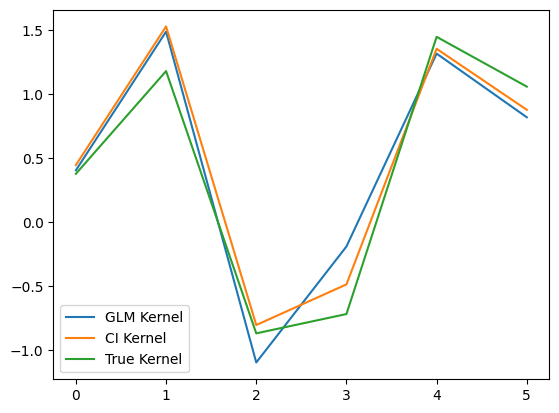

In [8]:
glm_kernel = GLMKernel.extract_single_kernel(data_df=responses_df, feature_id='feature', value_id='value', response_id='response')
ci_kernel = ClassificationImage.extract_single_kernel(data_df=responses_df, feature_id='feature', value_id='value', response_id='response')
plt.plot(GLMKernel.normalize_kernel(glm_kernel), label='GLM Kernel')
plt.plot(GLMKernel.normalize_kernel(ci_kernel), label='CI Kernel')
plt.plot(GLMKernel.normalize_kernel(obs.kernel), label='True Kernel')
plt.legend()



In [9]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,6.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'kernel_extractor':[ClassificationImage, GLMKernel]}        
                   
sim = Sim(SimpleExperiment, experiment_params, 
          LinearObserver, observer_params, 
          KernelDistance, analyser_params)
sim_df = sim.run_all(n_runs=10)

100%|██████████| 1220/1220 [00:05<00:00, 205.94it/s]


In [27]:
sim_df

,config,n_trials,trial_type,n_features,external_noise_std,kernel,internal_noise_std,criteria,kernel_extractor,run,corr
0,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,7,0.989799
1,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,9,0.996254
2,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,6,0.996972
3,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,3,0.993503
4,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,5,0.998589
...,...,...,...,...,...,...,...,...,...,...,...
1215,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,2,0.989934
1216,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,7,0.987563
1217,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,6,0.992239
1218,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,9,0.985724


<AxesSubplot: xlabel='internal_noise_std', ylabel='corr'>

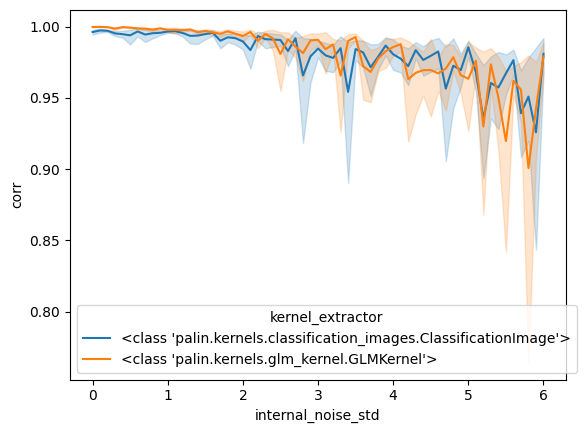

In [14]:
sns.lineplot(data=sim_df,
             x='internal_noise_std',
             y='corr',
             hue='kernel_extractor')

## Test GLMMethod

In [11]:
exp = SimpleExperiment(n_trials = 500,
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = 3, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)

In [20]:
norm_ci_value = GLMMethod.extract_norm_ci_value(data_df=responses_df)
norm_ci_value

12.574688648860807

In [21]:
model = GLMMethod.build_model()
model

100%|██████████| 490/490 [00:03<00:00, 123.49it/s]


In [23]:
estimated_noise_CI = norm_ci_value * model.params[1] + model.params[0]
estimated_noise_CI

2.225598361014603

In [ ]:
GLMMethod.extract_single_internal_noise(responses_df, kernel_extractor=GLMKernel)

100%|██████████| 490/490 [00:05<00:00, 90.40it/s] 


2.2990789511549043

## Compare CI with IN double_pass

In [28]:
internal_noise_std = np.arange(0.3, 5, 0.5)
n_trials = np.arange(100, 1000, 100)
random_kernel=[1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05]
results_fix = []

for n_trial in n_trials:
    exp = DoublePassExperiment(
        n_trials=n_trial,
        n_repeated=n_trial,
        trial_type=Int2Trial,
        n_features=7,
        external_noise_std=100
    )

    for noise in internal_noise_std:
        obs = LinearObserver(kernel=random_kernel,
                                 internal_noise_std=noise, 
                                 criteria=0)
        responses = obs.respond_to_experiment(exp)
        responses_df = Analyser.to_df(exp, responses)

        estimated_noise_CI=GLMMethod.extract_single_internal_noise(responses_df, kernel_extractor=GLMKernel)
        
        ana = InternalNoiseValue(internal_noise_extractor=DoublePass, model_file='model.csv')
        data = ana.analyse(exp, obs, responses)
        metrics = ana.get_metric_names()

        results_fix.append({
            'n_trials': n_trial,
            'internal_noise_std': noise,
            'estimated_noise_CI': estimated_noise_CI,
            metrics[0]: data[0],  
            metrics[1]: data[1]
        })
       
results_df = pd.DataFrame(results_fix)
results_df

100%|██████████| 490/490 [00:04<00:00, 100.95it/s]


,n_trials,internal_noise_std,estimated_noise_CI,estimated_internal_noise,estimated_criteria
0,100,0.3,2.124364,0.2,-2.000000e-01
1,100,0.8,1.594222,1.2,-1.000000e-01
2,100,1.3,1.572188,1.1,2.000000e-01
3,100,1.8,1.850936,0.6,2.000000e-01
4,100,2.3,2.101399,1.5,3.000000e-01
...,...,...,...,...,...
85,900,2.8,2.154651,3.3,-1.776357e-14
86,900,3.3,2.515100,3.4,9.000000e-01
87,900,3.8,2.653806,4.5,7.000000e-01
88,900,4.3,3.048628,3.9,-4.000000e-01


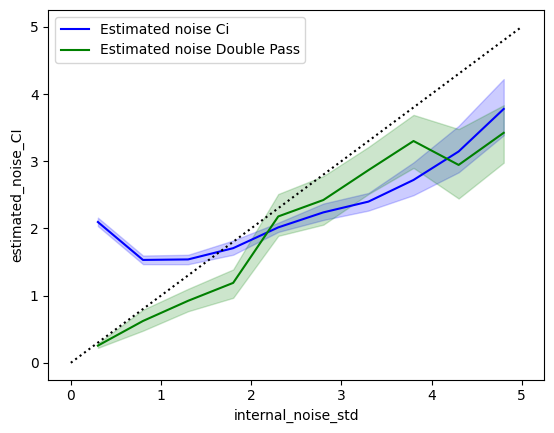

In [37]:
sns.lineplot(data=results_df, x='internal_noise_std', y='estimated_noise_CI', label='Estimated noise Ci', color='blue')
sns.lineplot(data=results_df, x='internal_noise_std', y='estimated_internal_noise', label='Estimated noise Double Pass', color='green')

plt.plot([0,5],[0,5],'k:')

<AxesSubplot: xlabel='internal_noise_std', ylabel='estimated_noise_CI'>

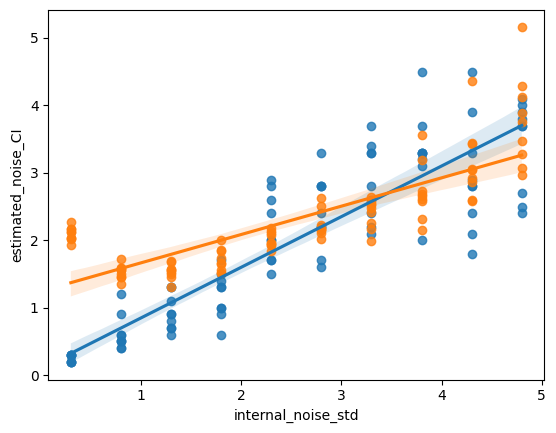

In [47]:
sns.regplot(data=results_df, x="internal_noise_std", y="estimated_internal_noise")
sns.regplot(data=results_df, x="internal_noise_std", y="estimated_noise_CI")


In [32]:
InternalNoiseValue(internal_noise_extractor=GLMMethod, kernel_extractor=GLMKernel).analyse(exp, obs, responses)

100%|██████████| 490/490 [00:04<00:00, 121.92it/s]


(4.195135621977944, None)

In [25]:
InternalNoiseValue(internal_noise_extractor=InterceptMethod, model_file='large_model.csv', kernel_extractor=ClassificationImage).analyse(exp, obs, responses)

ValueError: cannot insert response, already exists

In [ ]:
InterceptMethod.extract_single_internal_noise(responses_df, model_file='large_model.csv', kernel_extractor=ClassificationImage)

ValueError: cannot insert response, already exists

In [348]:
# InterceptMethod.extract_single_internal_noise(responses_df, model_file='large_model.csv', kernel_extractor=ClassificationImage)
# InternalNoiseValue(internal_noise_extractor=InterceptMethod, model_file='large_model.csv', kernel_extractor=ClassificationImage).analyse(exp, obs, responses)

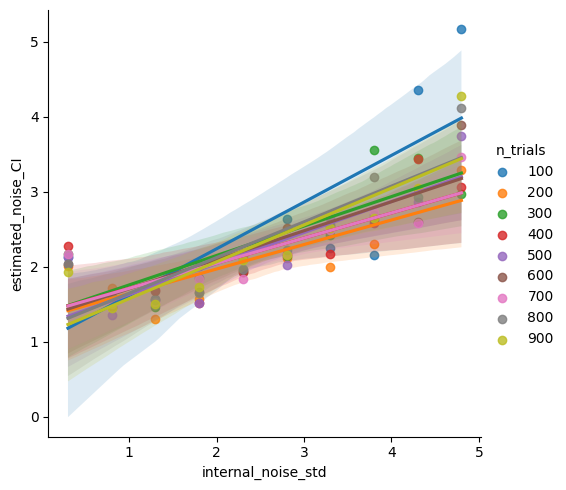

In [36]:
sns.lmplot(
   data=results_df,#[merged_df.n_trials > 200]
   x='internal_noise_std',
   y='estimated_noise_CI',
   hue='n_trials'
   #marker='o',
   #palette='viridis'
)

In [384]:
import statsmodels.formula.api as smf
model1 = smf.ols(formula="internal_noise_std ~ norm_max_feature_ci*n_trials", data=filtered_mean_ci_size_df).fit()
print(model1.params)
filtered_mean_ci_size_df['estimated_noise_CI'] = (filtered_mean_ci_size_df['norm_max_feature_ci'] * model1.params[1] + model1.params[0])

Intercept                      -1.052558
norm_max_feature_ci             0.440062
n_trials                       -0.001573
norm_max_feature_ci:n_trials    0.000159
dtype: float64


In [385]:
filtered_mean_ci_size_df

,internal_noise_std,n_trials,max_feature_ci,norm_max_feature_ci,estimated_internal_noise,estimated_criteria,estimated_noise_CI
0,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
1,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
2,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
3,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
4,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
...,...,...,...,...,...,...,...
562,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766
563,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766
564,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766
565,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766


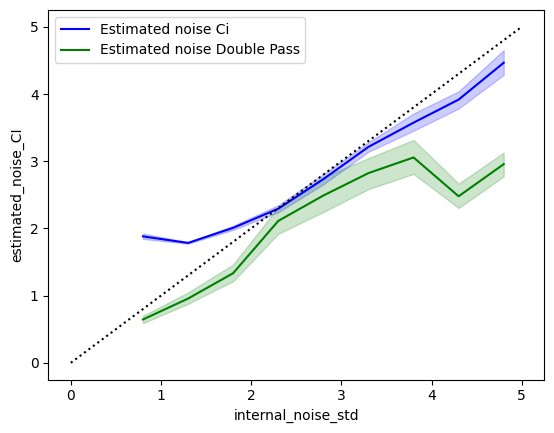

In [386]:
# sns.lineplot(data=filtered_mean_ci_size_df, x='internal_noise_std', y='norm_max_feature_ci', label='norm_max_feature_ci', color='red')
sns.lineplot(data=filtered_mean_ci_size_df, x='internal_noise_std', y='estimated_noise_CI', label='Estimated noise Ci', color='blue')
sns.lineplot(data=filtered_mean_ci_size_df, x='internal_noise_std', y='estimated_internal_noise', label='Estimated noise Double Pass', color='green')

plt.plot([0,5],[0,5],'k:')

## Intercept interval noise

In [85]:
InterceptMethod.compute_prob_agreement(responses_df,
                                       trial_id='trial',
                                       stim_id= 'stim',
                                       feature_id= 'feature',
                                       value_id = 'value',
                                       response_id='response',
                                       kernel_extractor=None)
        

0.7975201158150532

pivot dataframe to have one entry per trial

In [32]:
# group by trial and stim
df = responses_df.groupby(['trial','stim']).agg({'value':list, 'response':'first'}).reset_index()
df.value = df.value.apply(lambda x: np.array(x))
# for each trial, compute trial difference and which stim response
df = df.groupby(['trial']).agg({'value':lambda x:x.diff().iloc[1], #diff produces 2 lines, the first is nan
                           'response': lambda x: 0 if x.iloc[0] else 1}).reset_index()

What we need to compare is the projected difference on the kernel, i.e. if 2 trials are different in dimensions for which the kernel is null, then that difference doesn't matter

Generate all combinations of trials

In [33]:
from itertools import combinations
a, b = map(list, zip(*combinations(df.index, 2)))
comb_df = pd.concat(
    [df.loc[a].add_suffix('_1').reset_index(), df.loc[b].add_suffix('_2').reset_index()], axis=1, 
).drop(columns=['index'])

comb_df['value']=(comb_df.value_1 - comb_df.value_2)
# projected difference on the kernel (if 2 trials are different in dimensions for which the kernel is null, then that difference doesn't matter)
comb_df['proj_value']= comb_df.value.apply(lambda x: np.abs(x.dot(obs.kernel)))
# RMS of trial difference (i.e. trial difference of stim difference)
comb_df.value = comb_df.value.apply(lambda x: np.sqrt(np.sum(x**2)))
comb_df['agree']=(comb_df.response_1==comb_df.response_2).astype(int) 
comb_df = comb_df.drop(columns=['value_1','value_2','response_1','response_2'])

Relation between value & projected value is triangular: when value is small, proj_value can't be high; when value is high, proj_value can be whatever

<Axes: xlabel='value', ylabel='proj_value'>

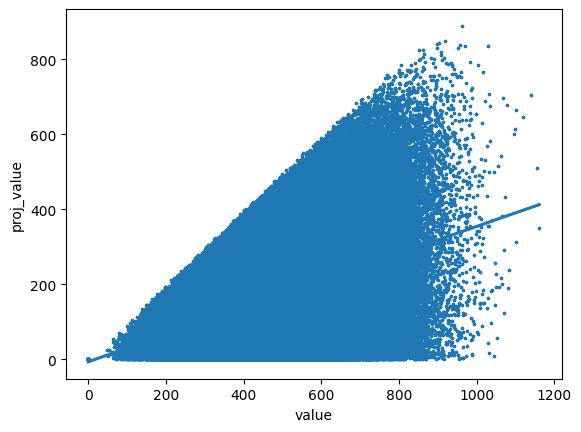

In [27]:
sns.regplot(data=comb_df, x='value',y='proj_value', scatter_kws={'s':2})

fit polynomial


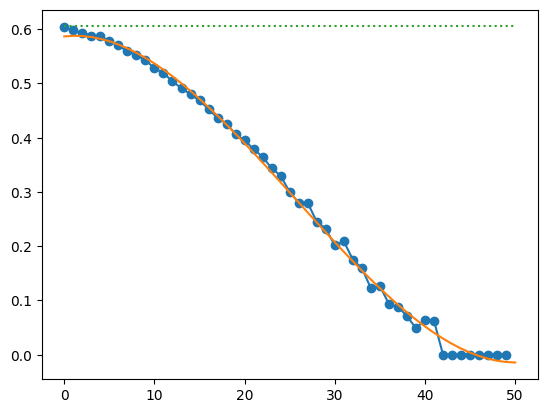

In [34]:
def binned_prob(data=comb_df, value='value',spacing='linear',nbins=100): 
    # get a separate bin for 0 (in case of double_pass)
    min_non_null = data[data[value]>0][value].min()
    if spacing == 'log': 
        bins = pd.cut(data[value],
                  bins=np.logspace(np.log10(min_non_null),
                                   np.log10(data[value].max()+1),nbins),
                  labels=False)
        bins = bins + 1 # increment all bins by 1
        bins = bins.fillna(0) # and give bin 0 to all that are < min_non_null 
    else: 
        bins = pd.cut(data[value],
                  bins=np.linspace(min_non_null,
                                   data[value].max()+1,nbins),
                  labels=False)
    bins = bins + 1 # increment all bins by 1
    bins = bins.fillna(0) # and give bin 0 to all that are < min_non_null 
    return data.groupby(bins).agree.mean().reset_index()
   
bins = binned_prob(comb_df,'proj_value',spacing='linear', nbins=50)
plt.plot(bins.proj_value, bins.agree, 'o-', label='proj linear')

#bins = binned_prob(comb_df,'value',spacing='linear',nbins=50)
#plt.plot(bins.value, bins.agree, 'o-', label='proj log')
#plt.legend()

print('fit polynomial')
try:
    poly = np.poly1d(np.polyfit(bins.proj_value[1:], bins.agree[1:], 3))
    plt.plot(x,poly(x), label='poly')
except RuntimeError: 
    print('fail')


# get p_agree groundtruth

p_agree, p_int1 = DoublePassStatistics().analyse(exp, obs, responses)
plt.plot([0,50],[p_agree,p_agree], ':')


In [29]:
from scipy.optimize import curve_fit
from scipy import stats

plt.plot(bins.proj_value, bins.agree, 'o', label='data')
x = np.linspace(0, 50, 50)

#popt, pcov = curve_fit(sigmoid, bins.proj_value, bins.agree, p0=[10,1])

#x = np.linspace(0, 50, 50)
#y = sigmoid(x, *popt)

#plt.plot(x,y, label='sigmoid')

print('fit exponential')
try: 
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    popt, pcov = curve_fit(func, bins.proj_value[1:], bins.agree[1:])
    plt.plot(x,func(x, *popt), label='exp')
except RuntimeError: 
    print('fail')

print('fit polynomial')
try:
    poly = np.poly1d(np.polyfit(bins.proj_value[1:], bins.agree[1:], 3))
    plt.plot(x,poly(x), label='poly')
except RuntimeError: 
    print('fail')

print('fit logistics')
try:
    def sigmoid(x, L ,x0, k, b):
        return L / (1 + np.exp(-k*(x-x0))) + b
    popt, pcov = curve_fit(sigmoid, bins.proj_value[1:], bins.agree[1:])
    plt.plot(x,sigmoid(x, *popt), label='sigmoid')
except RuntimeError: 
    print('fail')
plt.legend()

p_agree, p_int1 = DoublePassStatistics().analyse(exp, obs, responses)
plt.plot([0,50],[p_agree,p_agree], ':')


AttributeError: 'DataFrame' object has no attribute 'proj_value'

see influence of internal noise

IN: 0.0


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_18640\3851057835.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10,index+1)


IN: 0.6
IN: 1.1
IN: 1.7
IN: 2.2
IN: 2.8
IN: 3.3
IN: 3.9
IN: 4.4
IN: 5.0


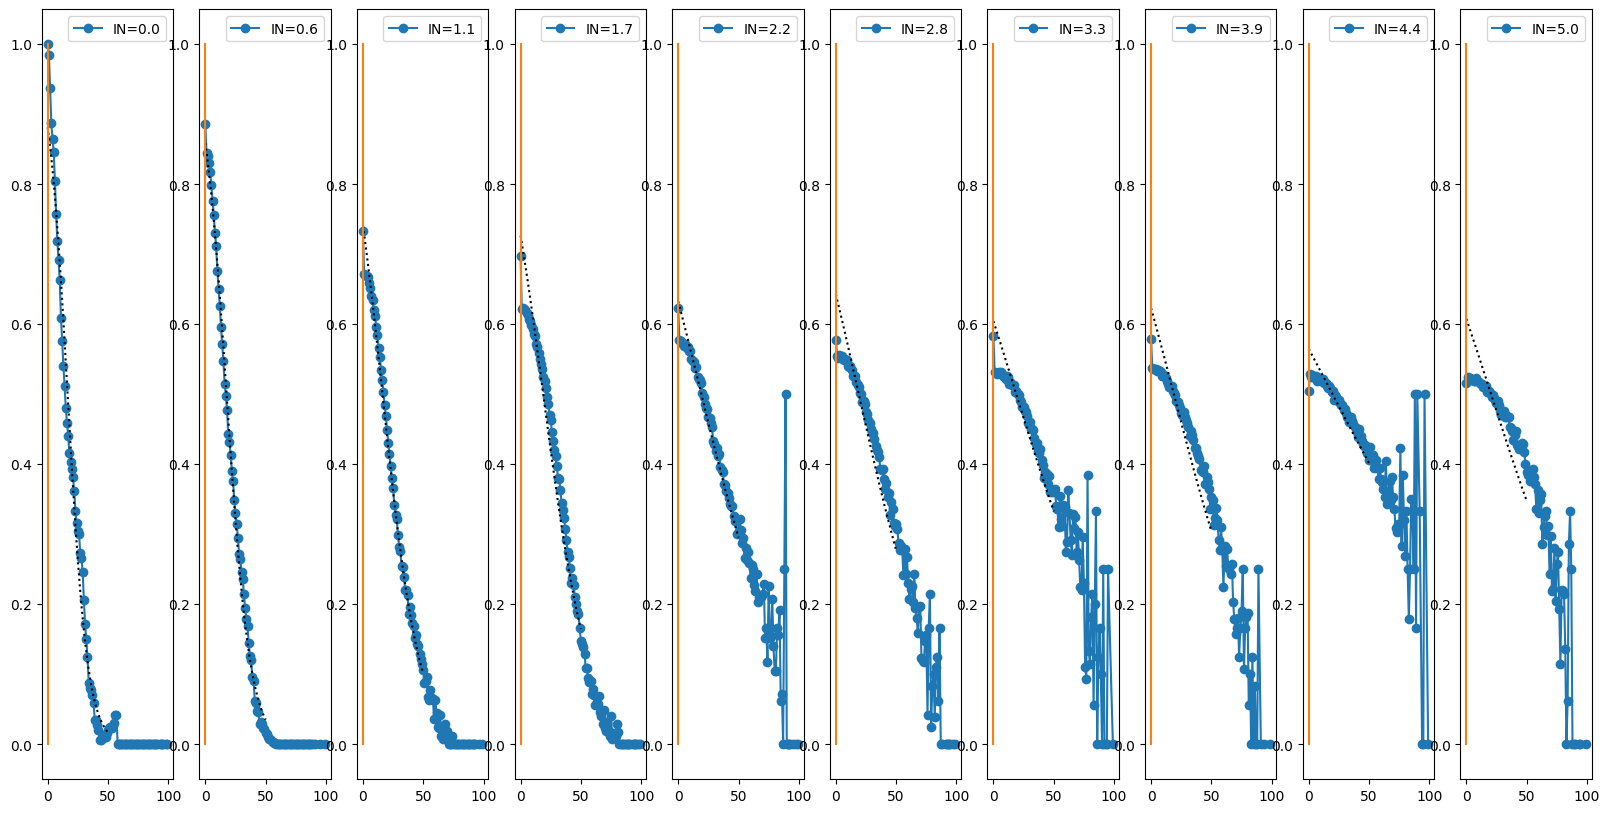

In [344]:
INs = np.linspace(0,5,10)

plt.subplots(figsize=(20,10))

exp = DoublePassExperiment(n_trials = 1000,n_repeated=1000, 
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)    
    
for index, internal_noise in enumerate(INs):
    
    print('IN: %.1f'%internal_noise)
    # simulate responses
    obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = internal_noise, 
                                        criteria = 0)
    responses = obs.respond_to_experiment(exp)
    responses_df = Analyser.to_df(exp, responses)
    
    # group by trial and stim
    df = responses_df.groupby(['trial','stim']).agg({'value':list, 'response':'first'}).reset_index()
    df.value = df.value.apply(lambda x: np.array(x))
    # for each trial, compute trial difference and which stim response
    df = df.groupby(['trial']).agg({'value':lambda x:x.diff().iloc[1], #diff produces 2 lines, the first is nan
                           'response': lambda x: 0 if x.iloc[0] else 1}).reset_index()
    
    from itertools import combinations
    a, b = map(list, zip(*combinations(df.index, 2)))
    comb_df = pd.concat(
        [df.loc[a].add_suffix('_1').reset_index(), df.loc[b].add_suffix('_2').reset_index()], axis=1, 
    ).drop(columns=['index'])

    comb_df['value']=(comb_df.value_1 - comb_df.value_2)
    comb_df['proj_value']= comb_df.value.apply(lambda x: np.abs(x.dot(obs.kernel)))
    comb_df['agree']=(comb_df.response_1==comb_df.response_2).astype(int) 
    comb_df = comb_df.drop(columns=['value_1','value_2','response_1','response_2'])
    
    bins = binned_prob(comb_df,'proj_value',50)
    plt.subplot(1,10,index+1)
    plt.plot(bins.proj_value, bins.agree, 'o-', label='IN=%.1f'%internal_noise)
    
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    popt, pcov = curve_fit(sigmoid, bins.proj_value, bins.agree)
    x = np.linspace(0, 50, 50)
    y = sigmoid(x, *popt)
    plt.plot(x,y, 'k:')
    plt.legend()
    plt.plot([0,0],[0,1])


## Simulate with internal noise

Single run

In [ ]:
# single run: 
exp = DoublePassExperiment(n_trials = 1000, n_repeated=200,
          trial_type = Int2Trial, 
          n_features = 5, 
          external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features, 
                            internal_noise_std = 1, 
                            criteria = 0)
responses = obs.respond_to_experiment(exp)
ana = InternalNoiseValue(internal_noise_extractor = DoublePass, model_file='model.csv')
data = ana.analyse(exp, obs, responses)
for name, value in zip(ana.get_metric_names(), data): 
    print("%s: %f"%(name, value))

Simulation

In [ ]:
observer_params = {'kernel':['random'],#[[0,0,0,0,0]]
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[200],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [1]}
analyser_params = {'internal_noise_extractor':[DoublePass], 
                   'model_file': ['model.csv'], 
                   'rebuild_model': [False]}
                   #'internal_noise_range':[np.arange(0,5.1,0.1)],
                   #'criteria_range':[np.arange(-5,5,0.1)],
                   #'n_runs':[2]}
                  
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)
sim_df = sim.run_all_single_thread(n_runs=1)



In [ ]:
sns.lineplot(data=sim_df, x='internal_noise_std', y='estimated_internal_noise')
plt.plot([0,5],[0,5],':')

## Experiment with multiprocessing

In [ ]:
observer_params = {'kernel':['random'],#[[0,0,0,0,0]]
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[200],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [1]}
analyser_params = {'internal_noise_extractor':[DoublePass], 
                   'model_file': ['model.csv'], 
                   'rebuild_model': [False]}
                   #'internal_noise_range':[np.arange(0,5.1,0.1)],
                   #'criteria_range':[np.arange(-5,5,0.1)],
                   #'n_runs':[2]}
                  
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)

sim.run_all_multi_thread(n_runs=1)


 50%|█████     | 1/2 [00:00<00:00,  1.38it/s]

In [ ]:
model = DoublePass.build_model(internal_noise_range=np.arange(0,5,.1),
                               criteria_range=np.arange(-5,5,.5),
                               n_repeated_trials=1000, n_runs=10)

In [ ]:
model.to_csv('model_large.csv')

## Simulate with kernels

Single run

In [ ]:
# single run: 
exp = SimpleExperiment(n_trials = 100,
          trial_type = Int2Trial, 
          n_features = 5, 
          external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = 5, 
                            internal_noise_std = 1, 
                            criteria = 0)
responses = obs.respond_to_experiment(exp)
ka = KernelDistance(LMMExtractor)
ka.analyse(exp, obs, responses)

In [ ]:
# obs = Obs.with_random_kernel(n_features=5, internal_noise_std=0, criteria=0)

observer_params = {'kernel':['random'],
                   'internal_noise_std':[1], 
                  'criteria':[0]}
experiment_params = {'n_trials':[100],#np.arange(1,1000,100),
                     'trial_type': [Int2Trial],
                     'n_features': np.arange(2,10,1),
                     'external_noise_std': [100]}
analyser_params = {'kernel_extractor':[ClassificationImage], 
                  'distance':['CORR']}


sim = Sim(SimpleExperiment, experiment_params, 
          LinearObserver, observer_params, 
          KernelDistance, analyser_params)
sim_df = sim.run_all(n_runs=10)






In [ ]:
sim_df

In [ ]:
sns.lineplot(data=sim_df, 
             x='n_features',
             y='corr')#, hue='n_features')